Neural Linear Model Uncertainty Quantification.

Translated to JAX from https://colab.research.google.com/drive/1bOS3CcLukgjs-0-spm5GvwTBK7jgoDnc?usp=sharing#scrollTo=YwmW2StCzixH

# 0. Imports, Dataset, and MLP Model

In [84]:
from typing import Sequence
from functools import partial

from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax.flatten_util import ravel_pytree
from jax import vmap, jit, value_and_grad, jacrev
import seaborn as sns
import optax
import ml_collections
from flax.training import train_state
from flax import linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from rebayes.base import RebayesParams
from rebayes.low_rank_filter.lofi import RebayesLoFi
from rebayes.low_rank_filter.lofi_inference import LoFiParams

rc = {
    "figure.constrained_layout.use": True,
    "axes.titlesize": 20,
    "figure.figsize": (12, 9),
}
sns.set_theme(style="darkgrid", palette="colorblind", rc=rc)

In [4]:
def generate_dataset(n_train, obs_var, key=0, in_between=False):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    
    if in_between:
        mask = jr.bernoulli(key, p=0.5, shape=(n_train,))
        key1, key2, subkey = jr.split(subkey, 3)
        X_train = (-2 * jr.uniform(key1, (n_train,)) - 1) * mask + \
            (2 * jr.uniform(key2, (n_train,)) + 1) * (1. - mask)
    else:
        X_train = jr.normal(key, (n_train,))

    w = jnp.array([-0.6667, -0.6012, -1.0172, -0.7687, 1.4680, -0.1678])
    def f(x, key):
        fx = w @ jnp.power(x, jnp.arange(len(w)))
        fx *= jnp.sin(jnp.pi * x)
        fx *= jnp.exp(-0.5 * (x**2)) / jnp.sqrt(2 * jnp.pi)
        return fx + obs_var * jr.normal(key)
    
    keys = jr.split(subkey, n_train)
    y_train = vmap(f)(X_train, keys)

    return X_train, y_train


In [5]:
def get_adamw_config(learning_rate=0.01, weight_decay=1e-4, batch_size=1, num_epochs=1):
    """Get the default hyperparameter configuration."""
    config = ml_collections.ConfigDict()
    config.learning_rate = learning_rate
    config.weight_decay = weight_decay
    config.batch_size = batch_size
    config.num_epochs = num_epochs
    return config


Generate full dataset

In [6]:
n_train = 200
obs_var = 0.1

X_train, y_train = generate_dataset(n_train, obs_var)
X_grid = jnp.linspace(-4, 4, 150)

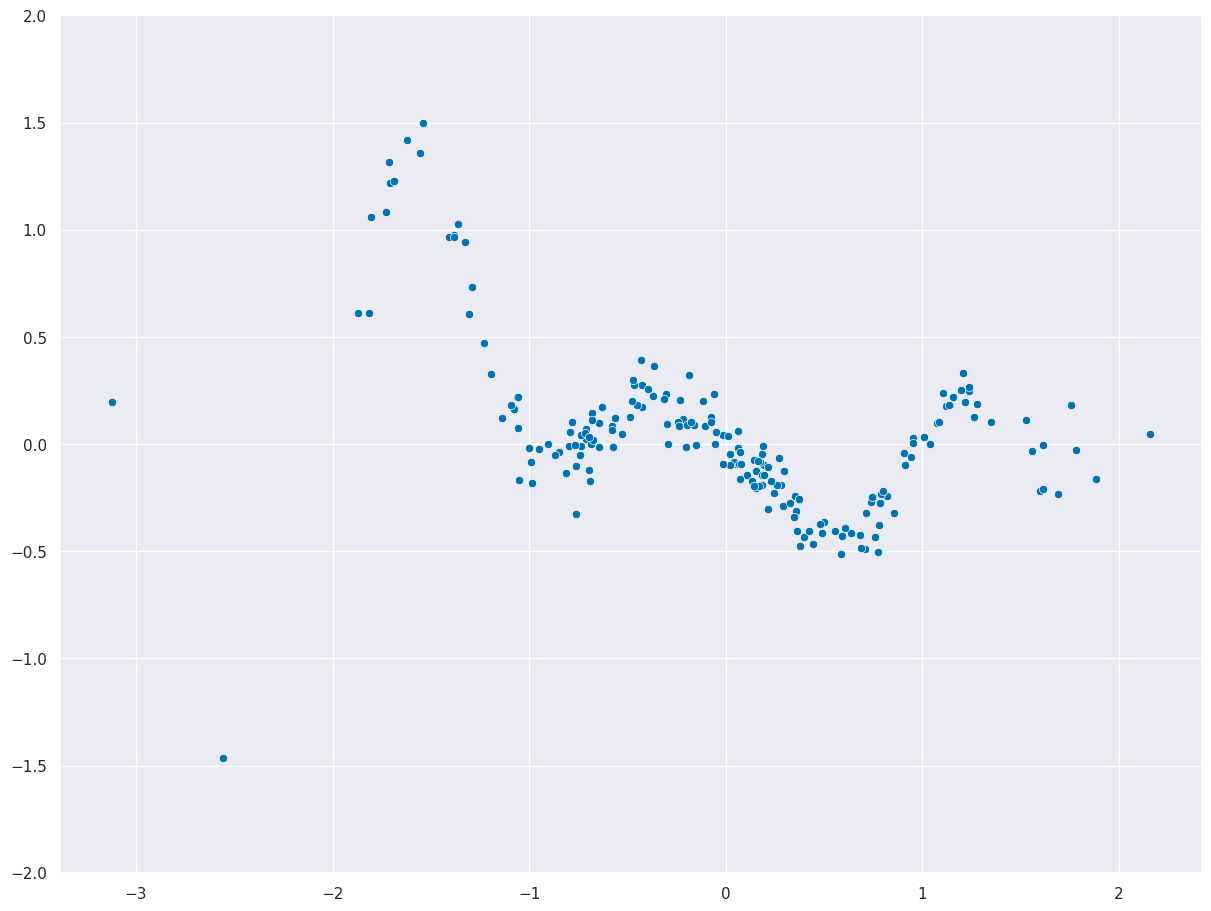

In [7]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax.set_ylim(-2., 2.);

Generate in-between dataset

In [8]:
X_inbtwn_train, y_inbtwn_train = generate_dataset(n_train, obs_var, in_between=True)

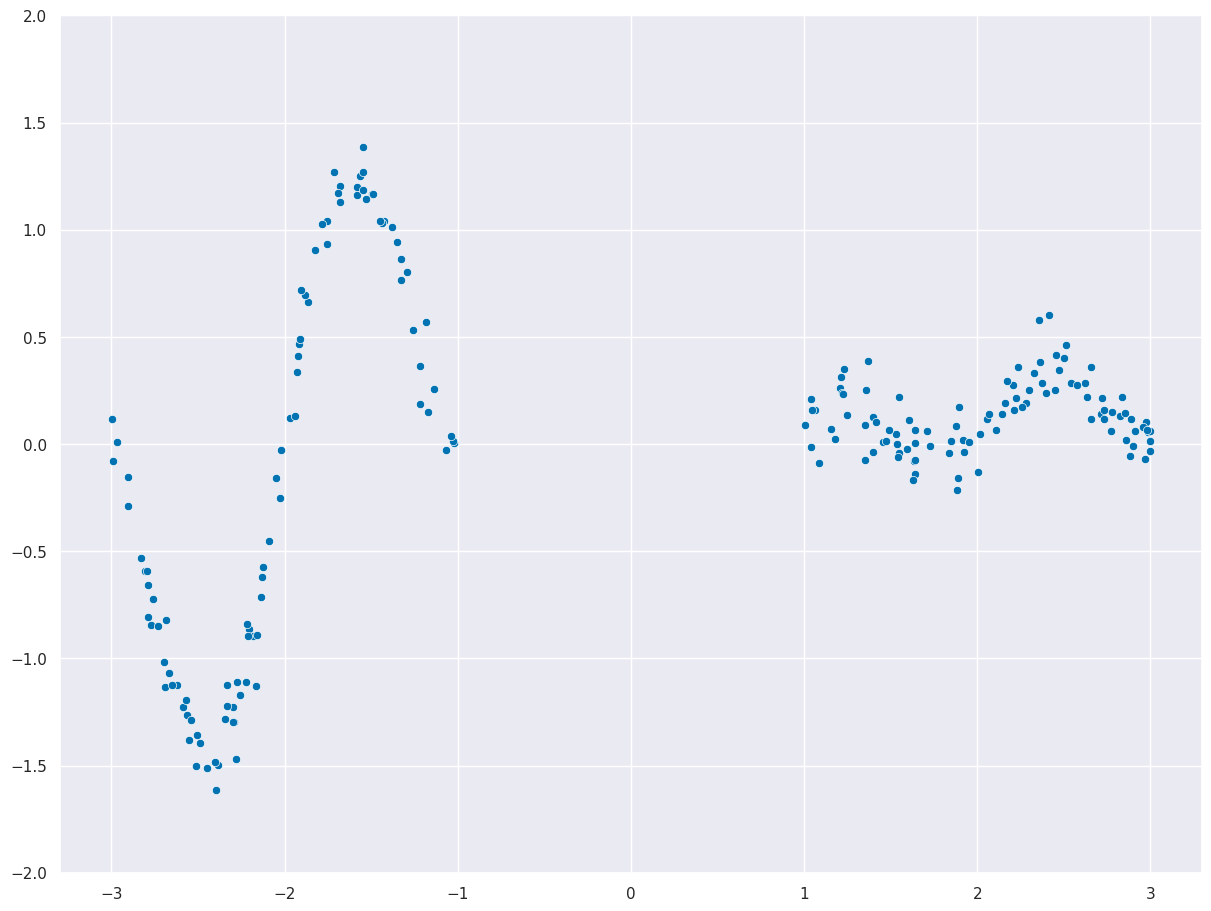

In [9]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax.set_ylim(-2., 2.);

Define an MLP model with separate features and output components to enable intermediate result extraction.

In [10]:
class MLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        self.penultimate = Features(self.features)
        self.output = Output()

    def __call__(self, x):
        x = self.penultimate(x)
        x = self.output(x)
        return x

class Features(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features:
            x = nn.relu(nn.Dense(feat)(x))
        return x

class Output(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Dense(1)(x)

In [11]:
n_features = 100
features = [n_features] * 3
model = MLP(features=features)
params = model.init(jr.PRNGKey(0), jnp.ones((1,)))
flat_params, unflatten_fn = ravel_pytree(params)
def apply(flat_params, x, model, unflatten_fn):
    return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))
apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

# Extract penultimate layer results
get_features = lambda params, x: model.apply(
    unflatten_fn(params), jnp.atleast_1d(x), 
    method=lambda module, x: module.penultimate(jnp.atleast_1d(x))
)
print(flat_params.shape)

(20501,)


# 1. Neural Linear Model 

## 1.1 Point Estimates

### 1.1.1 Full Dataset

In [12]:
config = get_adamw_config(
    learning_rate=1e-3, weight_decay=1/(2*0.95*n_train), batch_size=32, num_epochs=500
)

In [13]:
@jit
def compute_loss_and_updates(state, X_batch, y_batch):
    def loss_fn(params):
        preds = vmap(state.apply_fn, (None, 0))(params, X_batch).squeeze()
        loss = jnp.mean(optax.l2_loss(preds, y_batch))
        return loss

    grad_fn = value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    return grads, loss

In [14]:
def fit(config, apply_fn, flat_params, n_train, X_train, y_train):
    # Initialize the optimizer
    tx = optax.adamw(learning_rate=config.learning_rate, weight_decay=config.weight_decay)
    opt_state = train_state.TrainState.create(apply_fn=apply_fn, params=flat_params, tx=tx)

    for epoch in range(1, config.num_epochs+1):
        # Keep track of the loss
        train_loss = []

        # Shuffle the data at the beginning of each epoch
        key = jr.PRNGKey(epoch)
        perm = jr.permutation(key, n_train)
        perm = perm[:(n_train//config.batch_size)*config.batch_size].reshape(
            (n_train//config.batch_size, config.batch_size)
        )

        for batch in perm:
            X_batch, y_batch = X_train[batch], y_train[batch]
            grads, loss = compute_loss_and_updates(opt_state, X_batch, y_batch)
            opt_state = opt_state.apply_gradients(grads=grads)
            train_loss.append(loss)
        
        if epoch % 20 == 0:
            print(f"Epoch {epoch} - loss: {jnp.mean(jnp.array(train_loss))}")
    
    return opt_state

In [15]:
config = get_adamw_config(
    learning_rate=1e-3, weight_decay=1/(2*0.95*n_train), batch_size=32, num_epochs=500
)

In [16]:
trained_state = fit(config, apply_fn, flat_params, n_train, X_train, y_train)

Epoch 20 - loss: 0.04744509980082512
Epoch 40 - loss: 0.032280635088682175
Epoch 60 - loss: 0.04454308748245239
Epoch 80 - loss: 0.042777106165885925
Epoch 100 - loss: 0.04246431216597557
Epoch 120 - loss: 0.040642715990543365
Epoch 140 - loss: 0.039901867508888245
Epoch 160 - loss: 0.0352230966091156
Epoch 180 - loss: 0.029313018545508385
Epoch 200 - loss: 0.02274659089744091
Epoch 220 - loss: 0.015621062368154526
Epoch 240 - loss: 0.011271204799413681
Epoch 260 - loss: 0.010677361860871315
Epoch 280 - loss: 0.012288859114050865
Epoch 300 - loss: 0.010132746770977974
Epoch 320 - loss: 0.011321037076413631
Epoch 340 - loss: 0.010224323719739914
Epoch 360 - loss: 0.009148315526545048
Epoch 380 - loss: 0.008991716429591179
Epoch 400 - loss: 0.008961757645010948
Epoch 420 - loss: 0.008605836890637875
Epoch 440 - loss: 0.0086137093603611
Epoch 460 - loss: 0.008404191583395004
Epoch 480 - loss: 0.008881251327693462
Epoch 500 - loss: 0.007594983093440533


In [17]:
# Evaluate trained model on grid
y_preds = vmap(apply_fn, (None, 0))(trained_state.params, X_grid).squeeze()

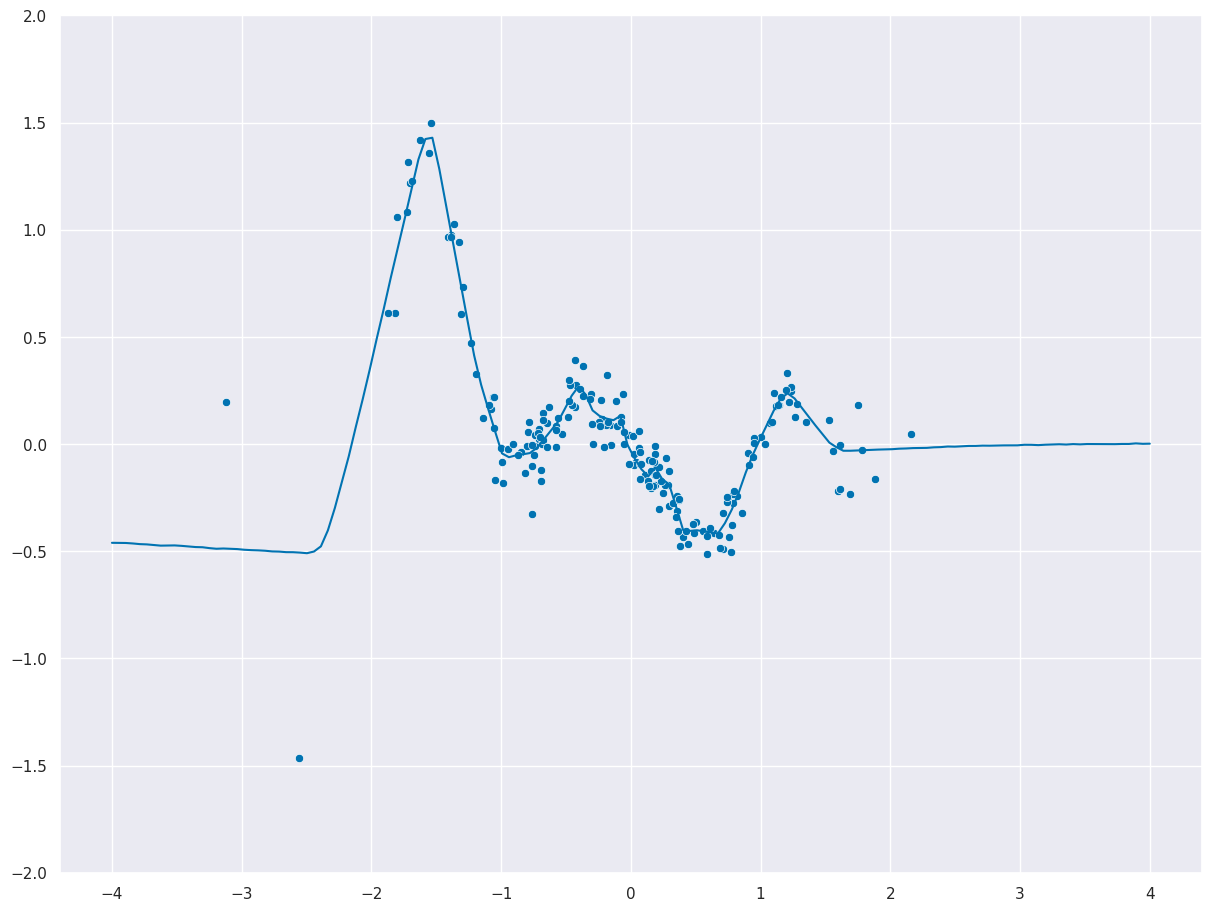

In [18]:
# Visualize the point-estimate results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_preds, ax=ax)
ax.set_ylim(-2., 2.);

### 1.1.2 In-Between Dataset

In [19]:
# Train on in-between data
trained_inbtwn_state = fit(config, apply_fn, flat_params, n_train, X_inbtwn_train, y_inbtwn_train)

Epoch 20 - loss: 0.19055545330047607
Epoch 40 - loss: 0.14883440732955933
Epoch 60 - loss: 0.11918588727712631
Epoch 80 - loss: 0.091006338596344
Epoch 100 - loss: 0.09027905762195587
Epoch 120 - loss: 0.05423681065440178
Epoch 140 - loss: 0.037861064076423645
Epoch 160 - loss: 0.027327150106430054
Epoch 180 - loss: 0.016458477824926376
Epoch 200 - loss: 0.014306670054793358
Epoch 220 - loss: 0.011491959914565086
Epoch 240 - loss: 0.009136129170656204
Epoch 260 - loss: 0.013016311451792717
Epoch 280 - loss: 0.009809167124330997
Epoch 300 - loss: 0.008425982668995857
Epoch 320 - loss: 0.009704437106847763
Epoch 340 - loss: 0.010449027642607689
Epoch 360 - loss: 0.007794423960149288
Epoch 380 - loss: 0.008366381749510765
Epoch 400 - loss: 0.009181584231555462
Epoch 420 - loss: 0.01413695141673088
Epoch 440 - loss: 0.01616911217570305
Epoch 460 - loss: 0.008718106895685196
Epoch 480 - loss: 0.0072374409064650536
Epoch 500 - loss: 0.007898799143731594


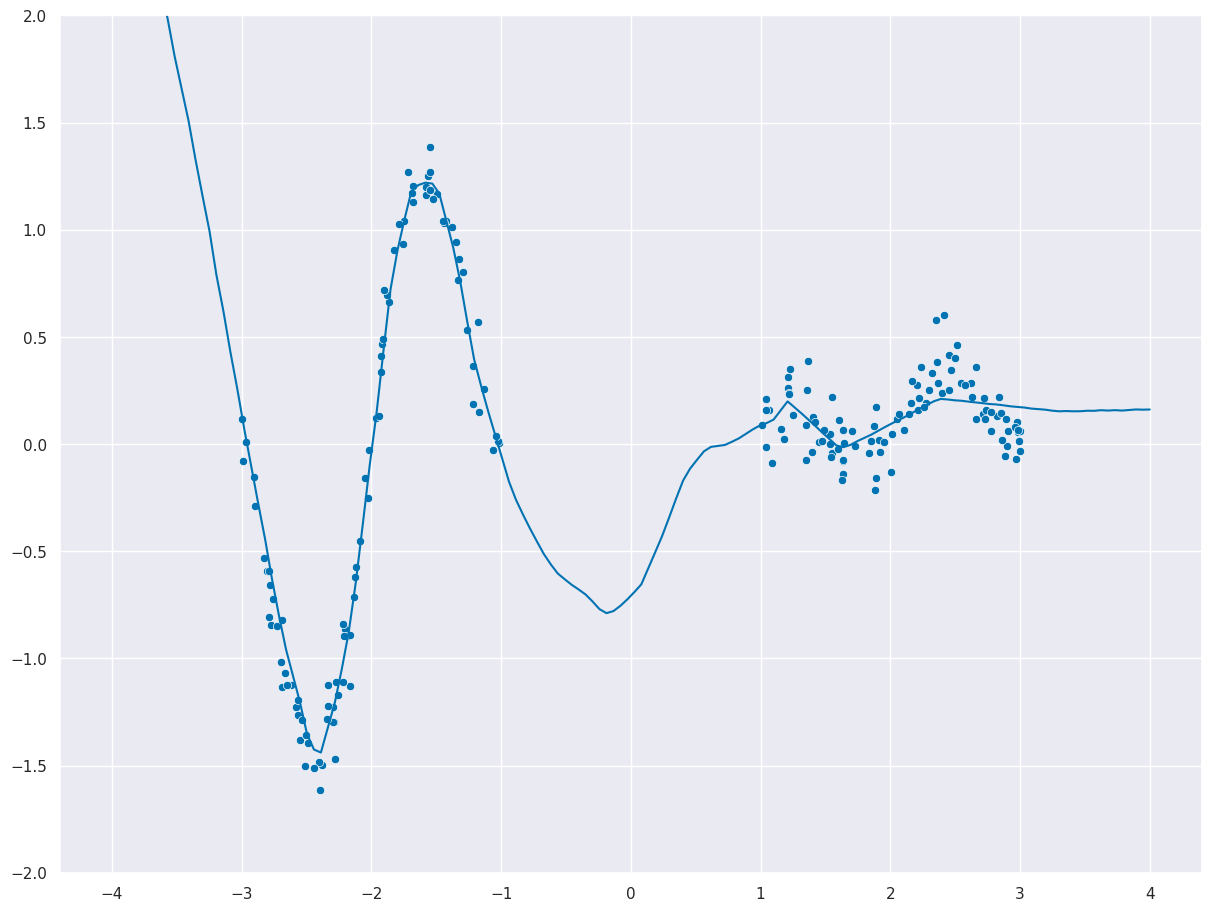

In [20]:
# Evaluate trained model on grid
y_inbtwn_preds = vmap(apply_fn, (None, 0))(trained_inbtwn_state.params, X_grid).squeeze()

# Visualize the point-estimate results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_inbtwn_preds, ax=ax)
ax.set_ylim(-2., 2.);

## 1.2 Uncertainty Estimates

### 1.2.1 Full Dataset

In [21]:
# Compute penultimate layer results
phi_train = vmap(get_features, (None, 0))(trained_state.params, X_train)
phi_test = vmap(get_features, (None, 0))(trained_state.params, X_grid)
print(phi_train.shape, phi_test.shape)

(200, 100) (150, 100)


To compute the posterior covariance, we treat the final layer as a Bayesian linear regression model and analytically solve for $\phi(x)^{\top}\left(\sigma^{-2}\phi(X_{\text{train}})^{⊤} \phi(X_{\text{train}}) + \mathbf{I}\right)^{-1}\phi(x)$.

In [46]:
post_cov = phi_test @ jnp.linalg.pinv(phi_train.T @ phi_train/obs_var + jnp.eye(n_features)) @ phi_test.T
post_cov += 1e-2 * jnp.eye(len(post_cov)) # to ensure positive definiteness
post_std = jnp.sqrt(jnp.diag(post_cov))

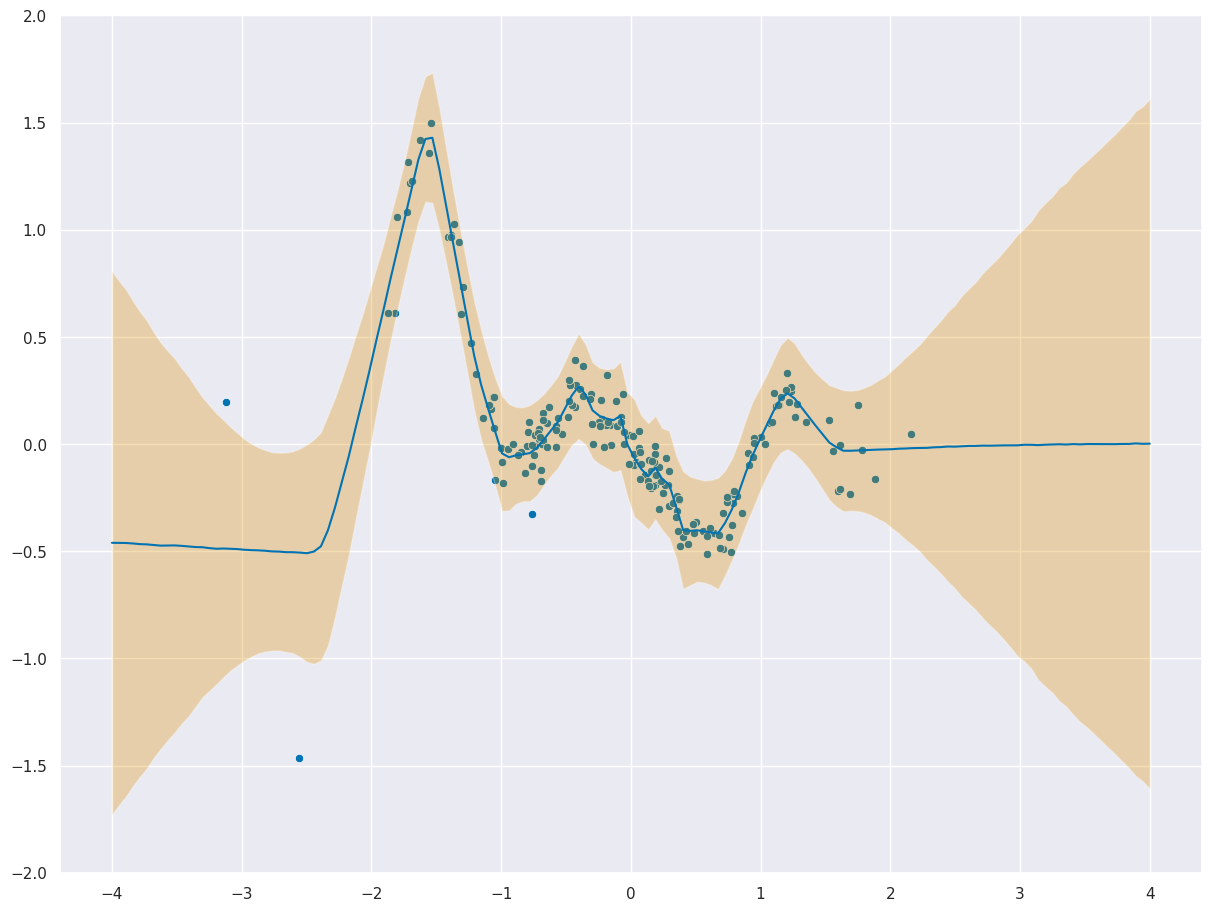

In [47]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_preds, ax=ax)
ax.fill_between(
    X_grid, y_preds - 1.96*post_std, y_preds + 1.96*post_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

### 1.2.2 In-Between Dataset

In [48]:
# Compute penultimate layer results
phi_inbtwn_train = vmap(get_features, (None, 0))(trained_inbtwn_state.params, X_inbtwn_train)
phi_inbtwn_test = vmap(get_features, (None, 0))(trained_inbtwn_state.params, X_grid)
print(phi_inbtwn_train.shape, phi_inbtwn_test.shape)

(200, 100) (150, 100)


In [49]:
post_inbtwn_cov = phi_inbtwn_test @ jnp.linalg.pinv(phi_inbtwn_train.T @ phi_inbtwn_train/obs_var + jnp.eye(n_features)) @ phi_inbtwn_test.T
post_inbtwn_cov += 1e-2 * jnp.eye(len(post_inbtwn_cov)) # to ensure positive definiteness
post_inbtwn_std = jnp.sqrt(jnp.diag(post_inbtwn_cov))

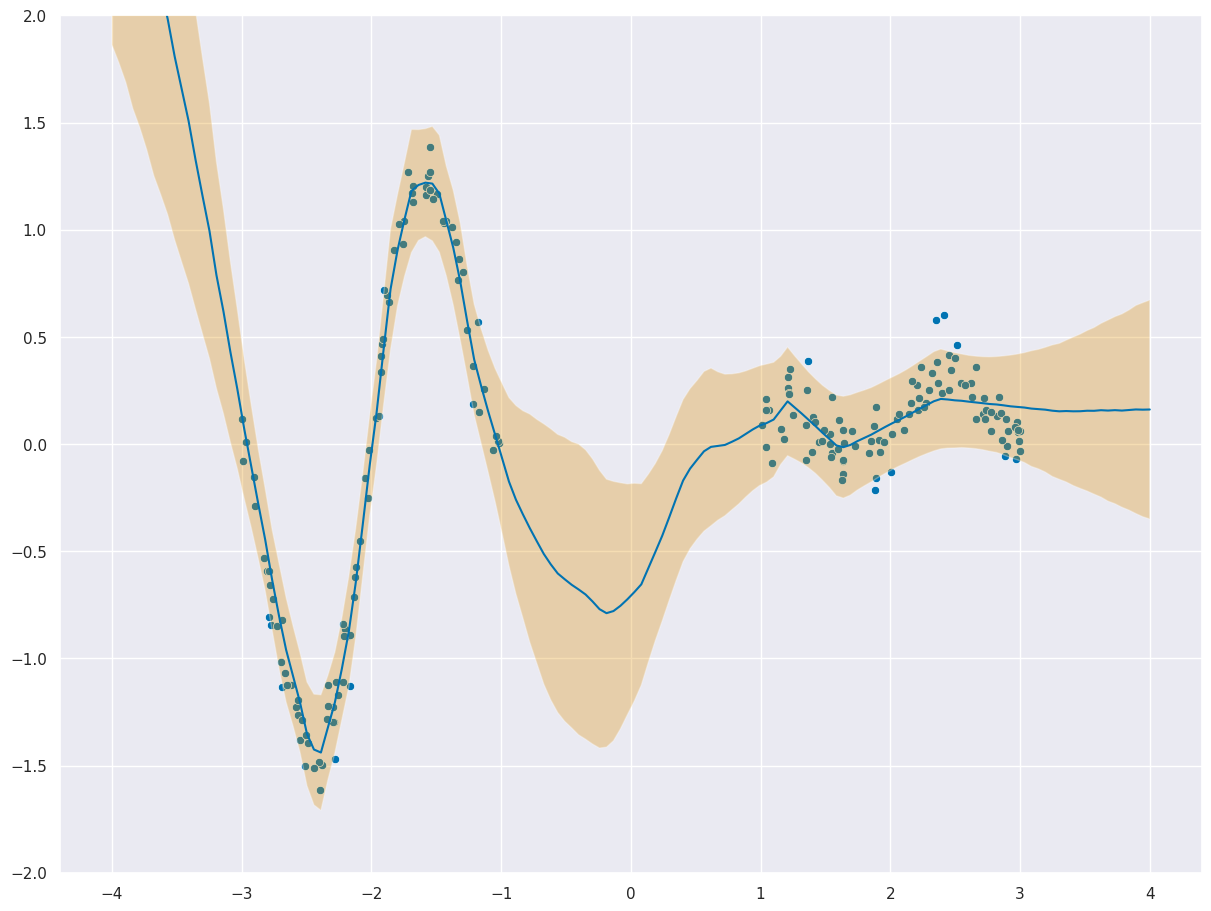

In [50]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=y_inbtwn_preds, ax=ax)
ax.fill_between(
    X_grid, y_inbtwn_preds - 1.96*post_inbtwn_std, y_inbtwn_preds + 1.96*post_inbtwn_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

## 1.3 Posterior Predictive Sampling

### 1.3.1 Full Dataset

In [51]:
# Take 100 samples from the posterior predictive distribution
f_samples = MVN(loc=y_preds, covariance_matrix=post_cov).sample((100,), seed=jr.PRNGKey(0))

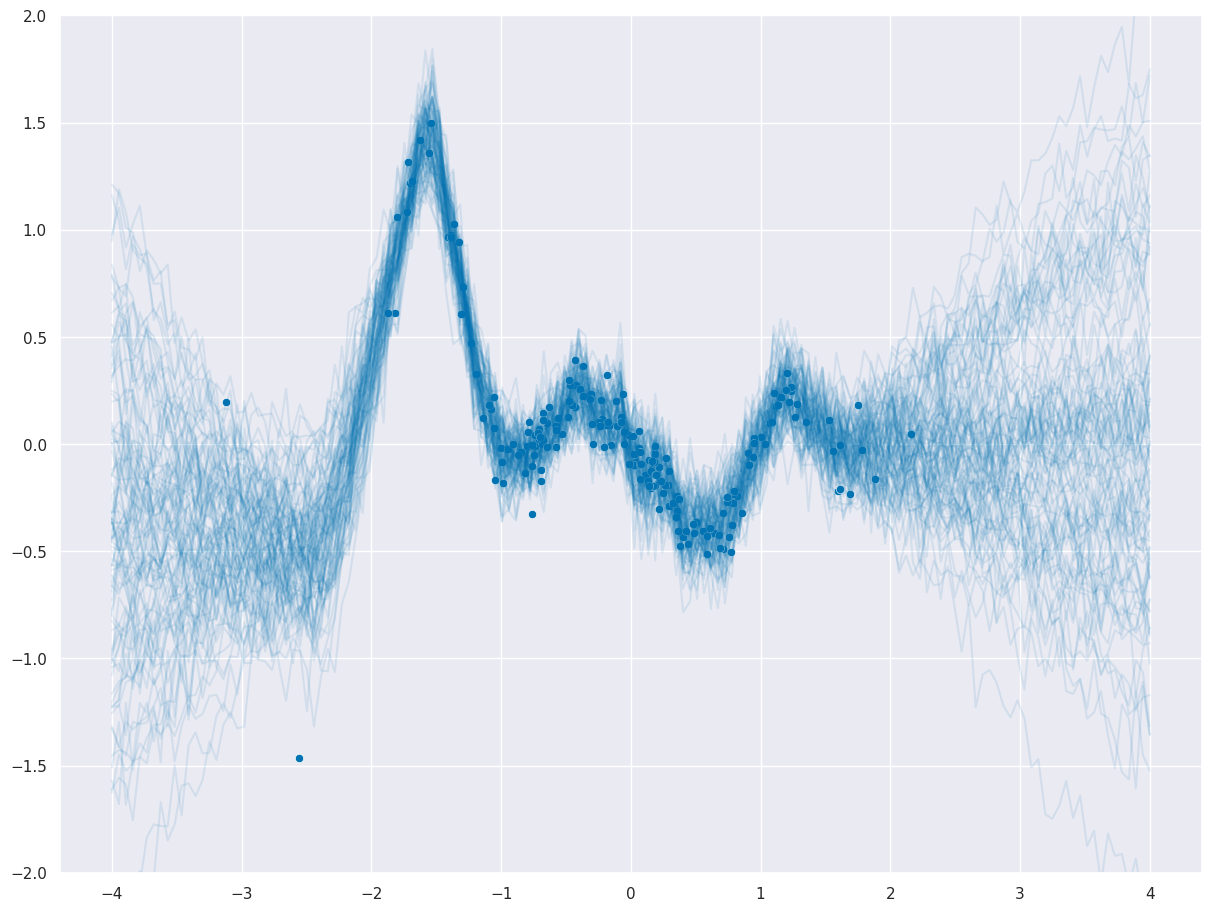

In [52]:
# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
for func in f_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);

### 1.3.2 In-Between Dataset

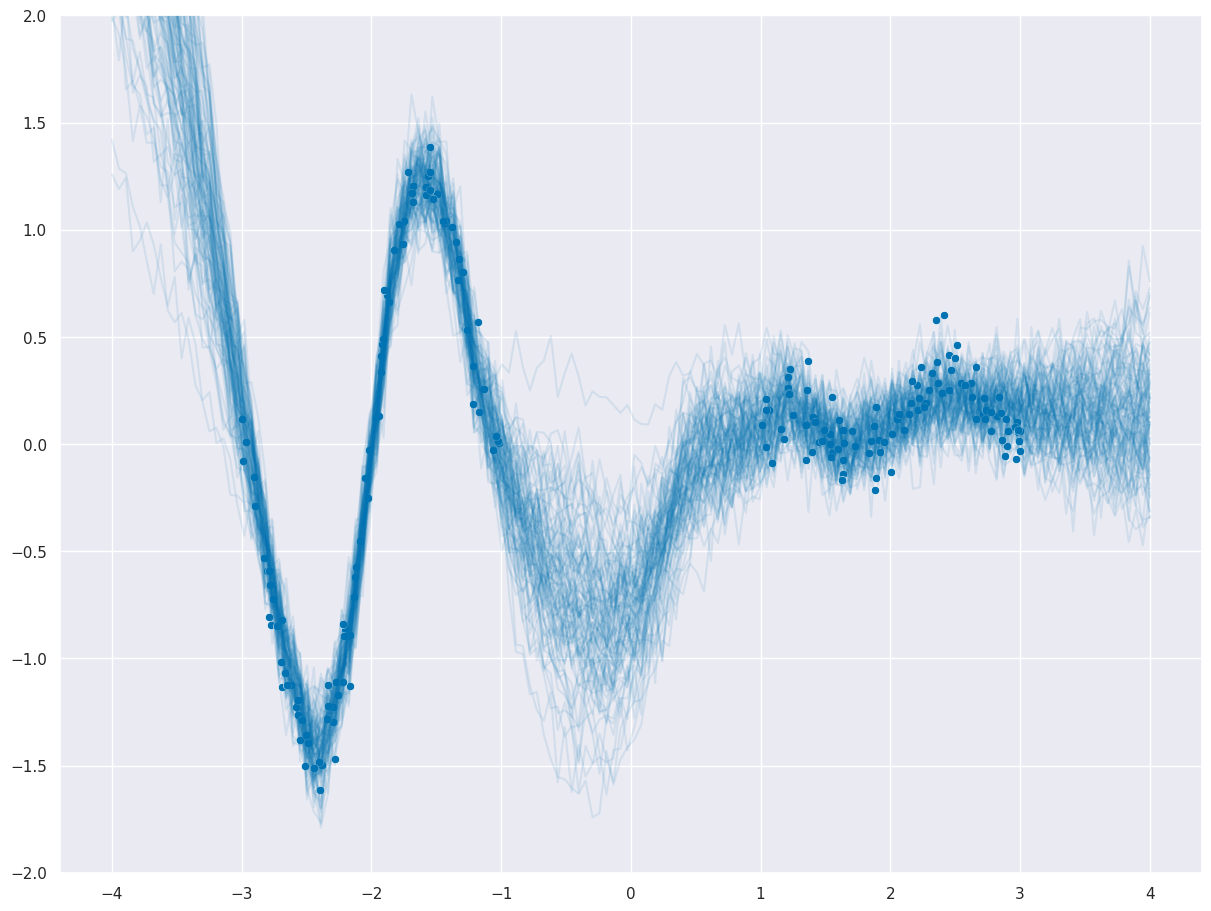

In [53]:
# Take 100 samples from the posterior predictive distribution
f_inbtwn_samples = MVN(loc=y_inbtwn_preds, covariance_matrix=post_inbtwn_cov).sample((100,), seed=jr.PRNGKey(0))

# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
for func in f_inbtwn_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);

# 2. ORFit

In [57]:
# Initialize orfit estimator
model_params = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=None,
    dynamics_weights=None,
    dynamics_covariance=None,
    emission_mean_function=apply_fn,
    emission_cov_function = lambda w, x: None,
)
orfit_params1 = LoFiParams(
    memory_size=n_train,
)
orfit_params2 = LoFiParams(
    memory_size=32,
)

estimator = RebayesLoFi(model_params, orfit_params1, method='orfit')
estimator2 = RebayesLoFi(model_params, orfit_params2, method='orfit')

In [58]:
def orfit_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_basis):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T

    return pred_mean, pred_cov

## 2.1 Full Dataset

### 2.1.1 Single-Pass

In [59]:
# Run Infinite-memory ORFit on the dataset
bel, _ = estimator.scan(X_train, y_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 2247.02it/s]


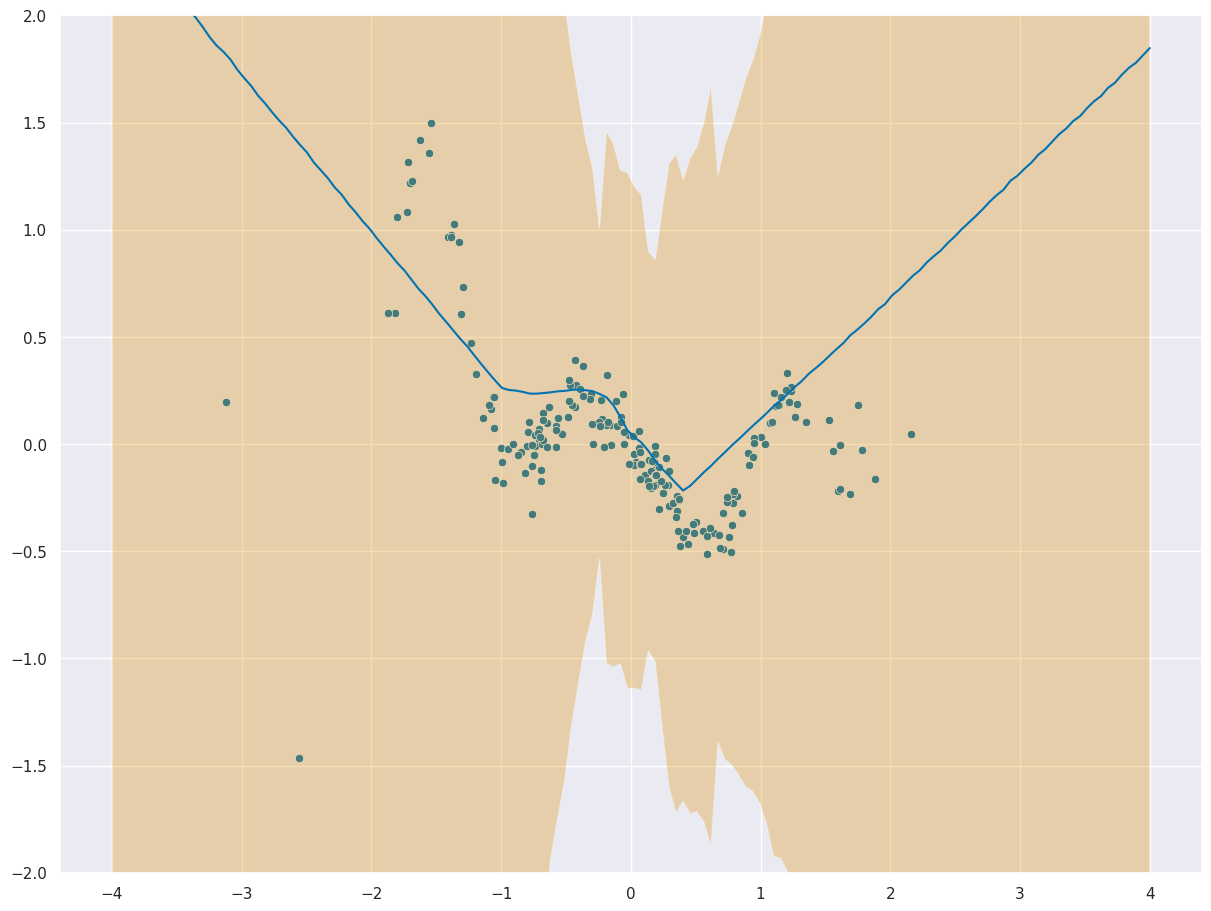

In [60]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

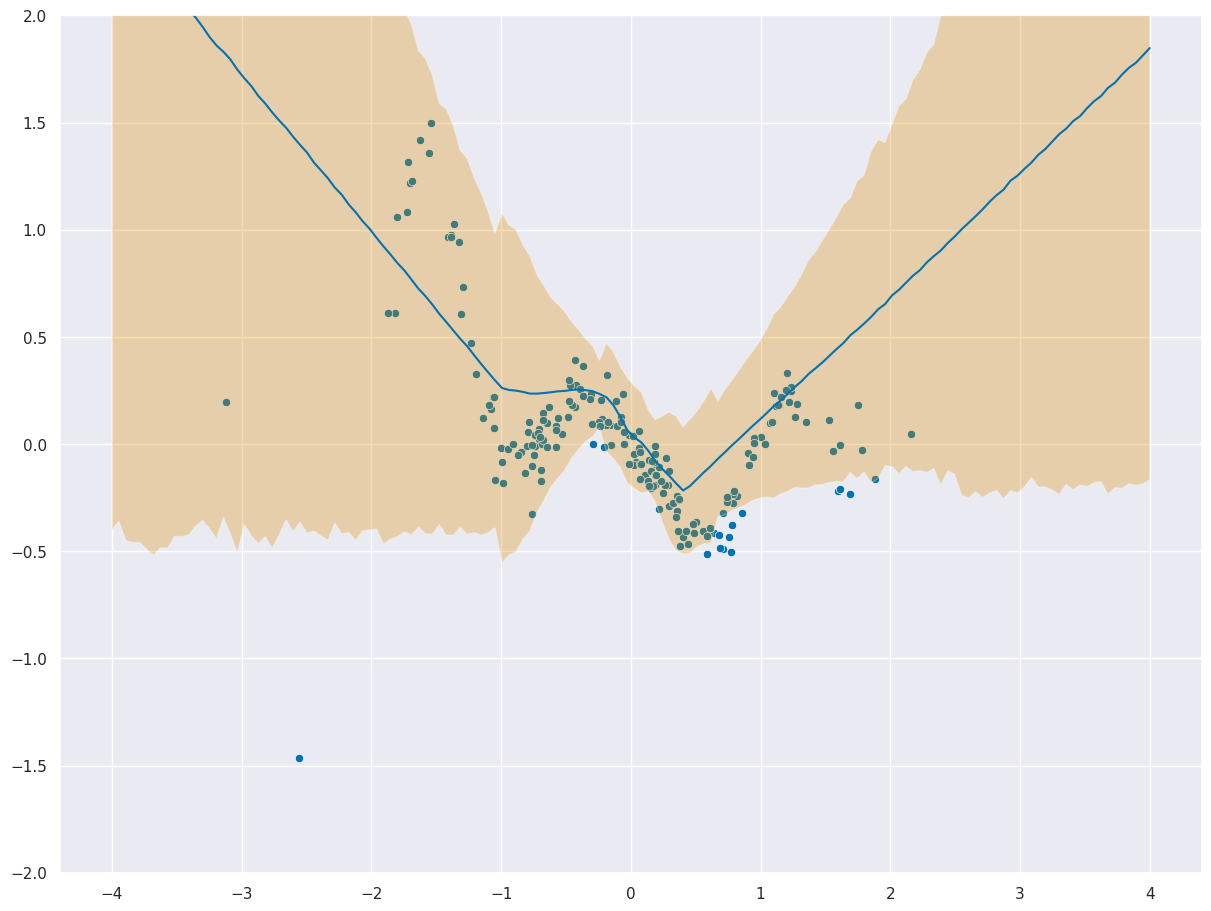

In [61]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

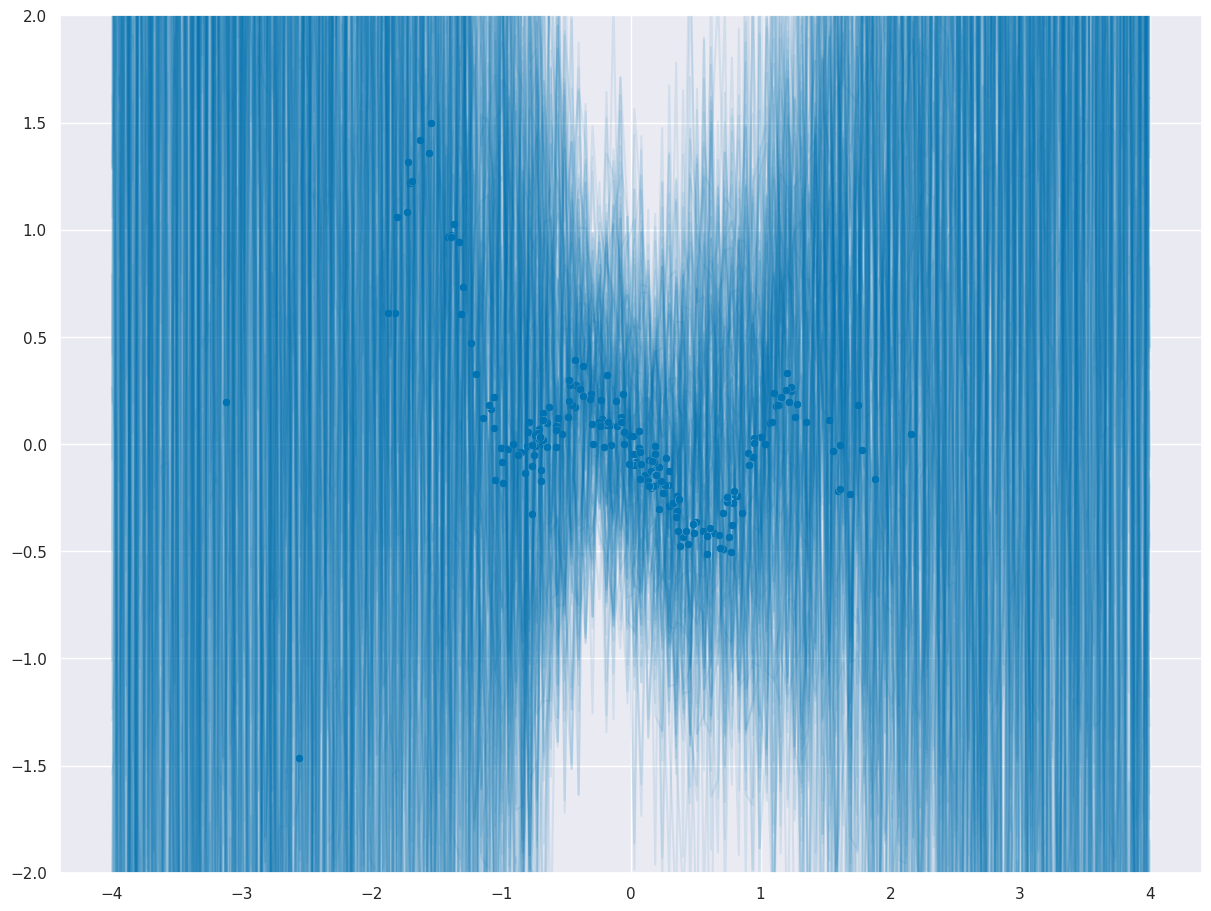

In [62]:
# Take 100 samples from the posterior predictive distribution
f_samples = MVN(loc=pred_mean, covariance_matrix=pred_cov).sample((100,), seed=jr.PRNGKey(0))

# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
for func in f_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);

## 2.1.2 Multiple Passes (n=50)

In [63]:
# 50 passes over the dataset
n_passes = 50
X_multiple_train, y_multiple_train = jnp.tile(X_train, n_passes), jnp.tile(y_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [64]:
# Run ORFit with memory equal to size of original training set
bel, _ = estimator2.scan(X_multiple_train, y_multiple_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 10,000 iterations: 100%|██████████| 10000/10000 [00:03<00:00, 3134.22it/s]


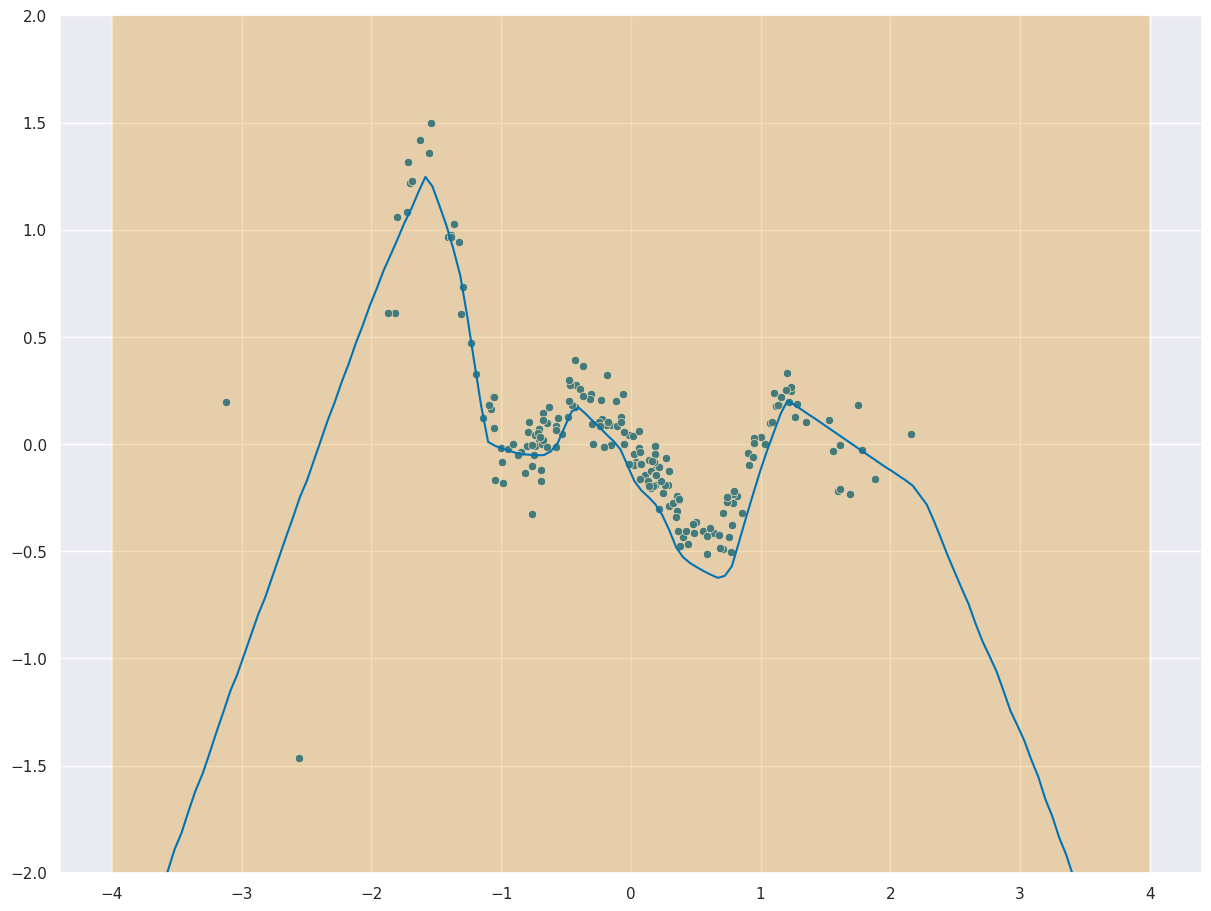

In [65]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

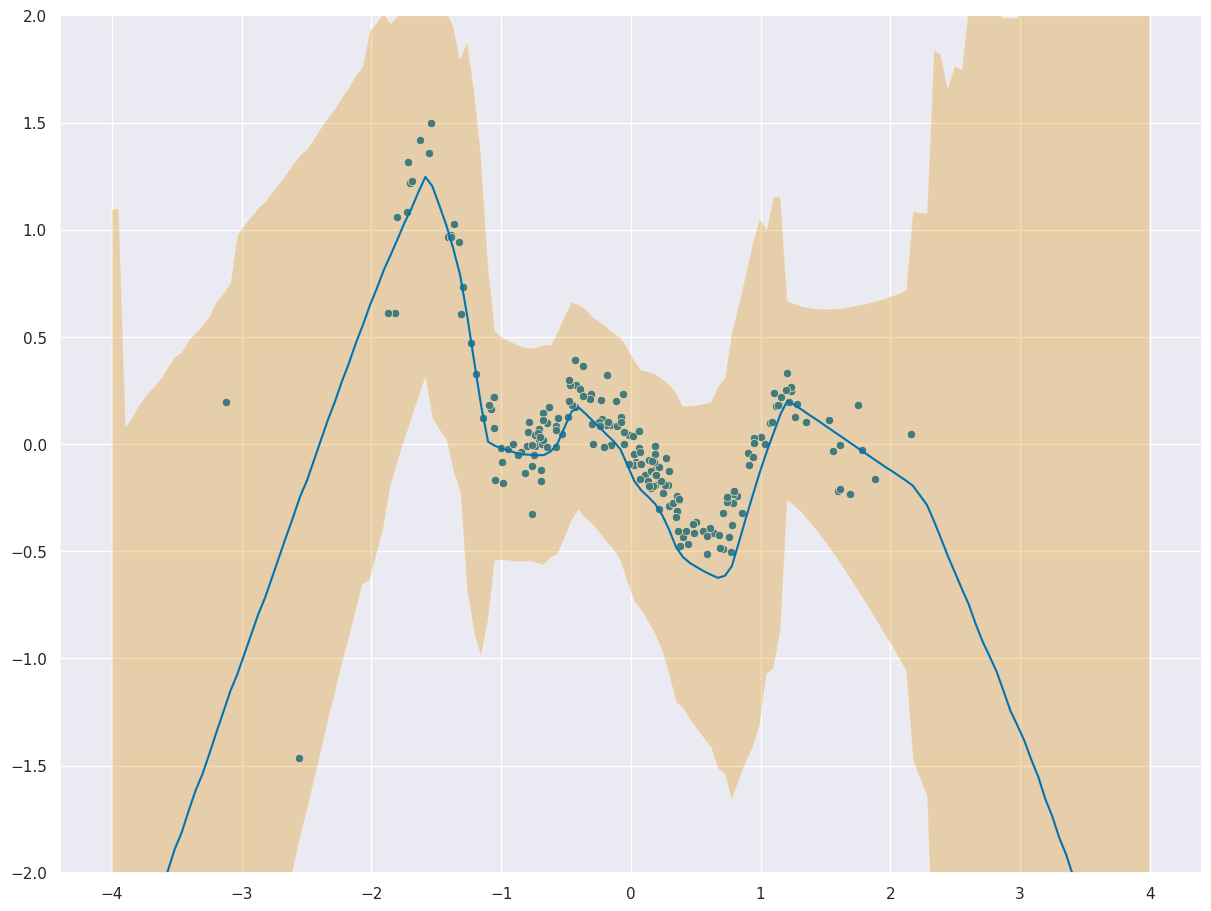

In [66]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

## 2.1.3 Multiple Passes (n=500)

In [67]:
# 500 passes over the dataset
n_passes = 500
X_multiple_train, y_multiple_train = jnp.tile(X_train, n_passes), jnp.tile(y_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [68]:
# Run ORFit with memory equal to size of original training set
bel, _ = estimator2.scan(X_multiple_train, y_multiple_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 100,000 iterations: 100%|██████████| 100000/100000 [00:31<00:00, 3127.28it/s]


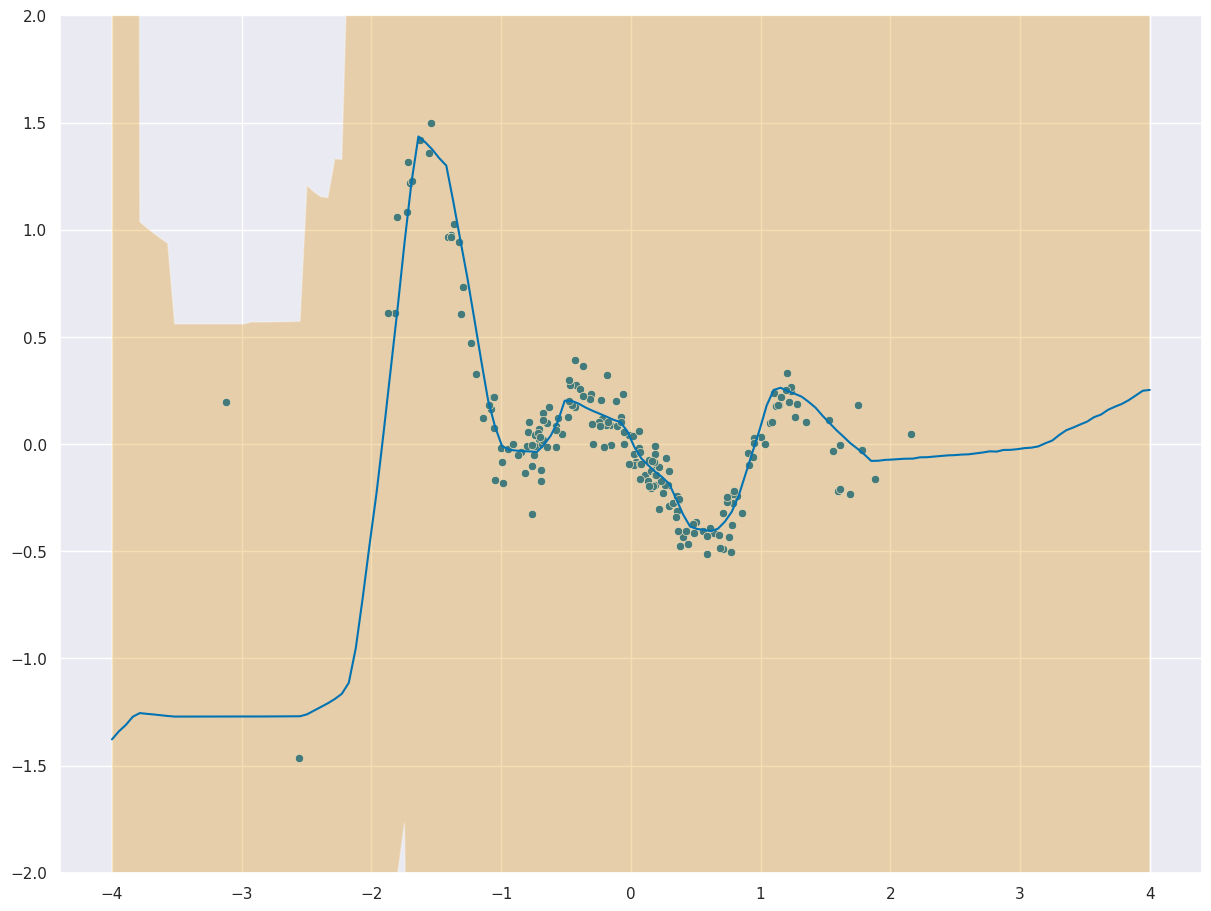

In [69]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

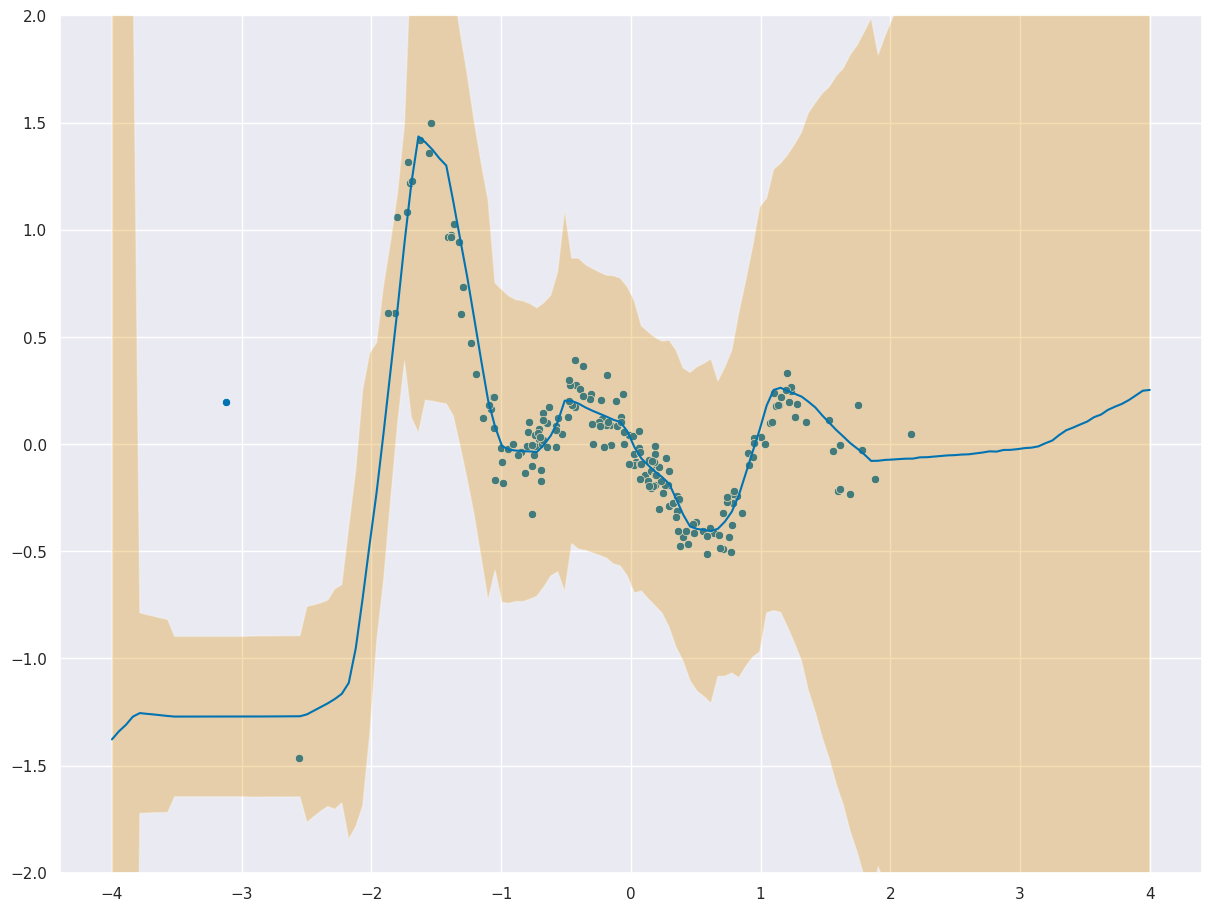

In [70]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

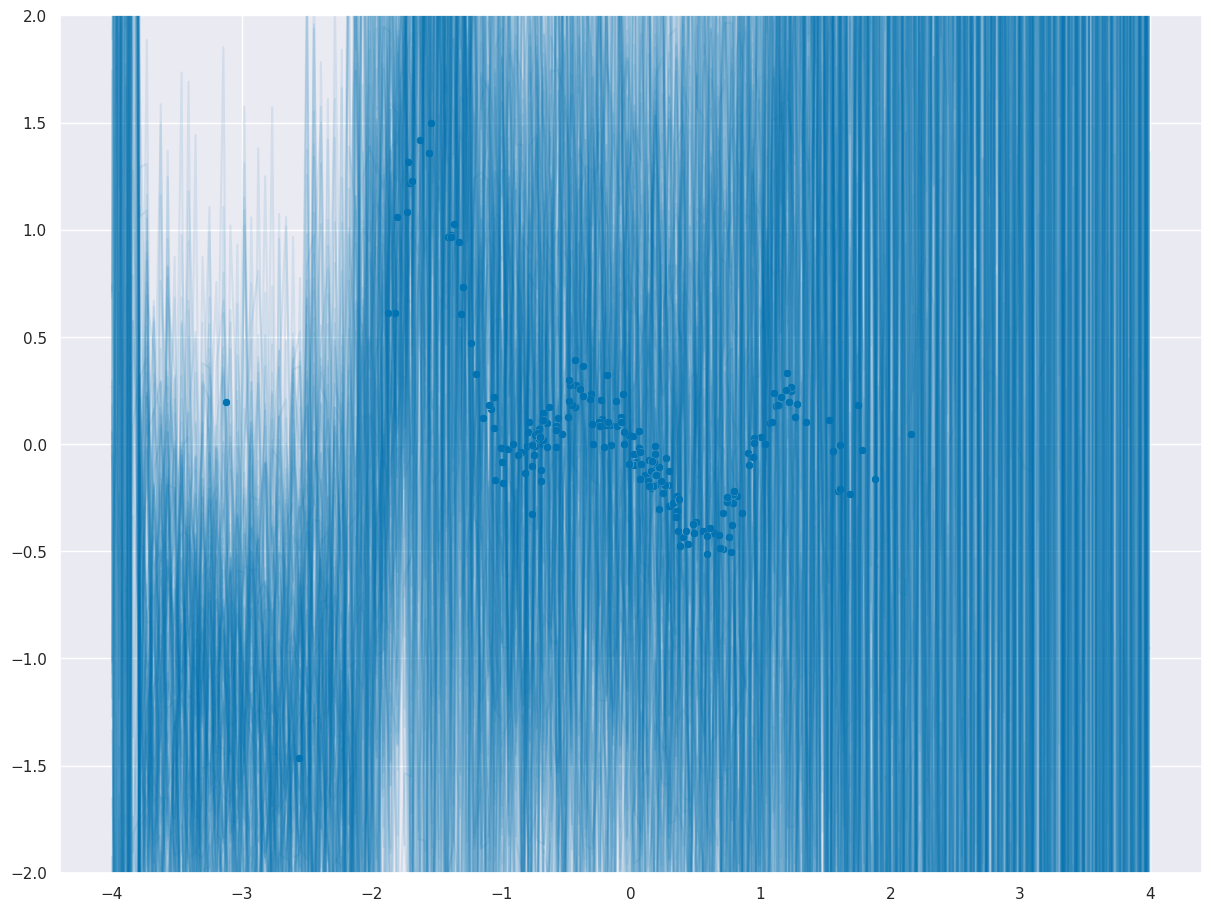

In [71]:
# Take 100 samples from the posterior predictive distribution
f_samples = MVN(loc=pred_mean, covariance_matrix=pred_cov).sample((100,), seed=jr.PRNGKey(0))

# Visualize the distribution of samples
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
for func in f_samples:
    ax = sns.lineplot(x=X_grid, y=func, ax=ax, color='C0', alpha=0.1)
ax.set_ylim(-2., 2.);

## 2.2 In-Between Dataset

### 2.2.1 Single-Pass

In [72]:
# Run Infinite-memory ORFit on the dataset
bel, _ = estimator.scan(X_inbtwn_train, y_inbtwn_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 2113.76it/s]


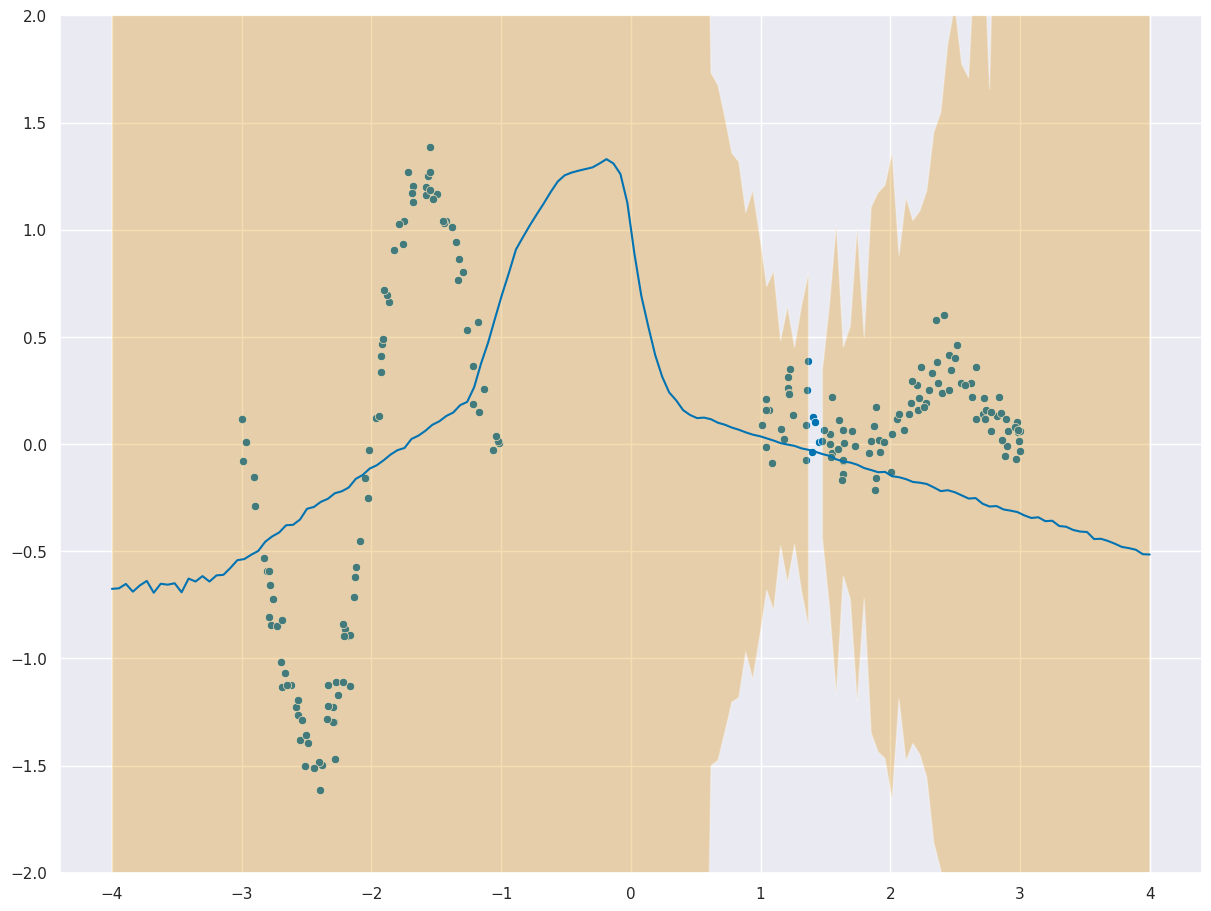

In [73]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

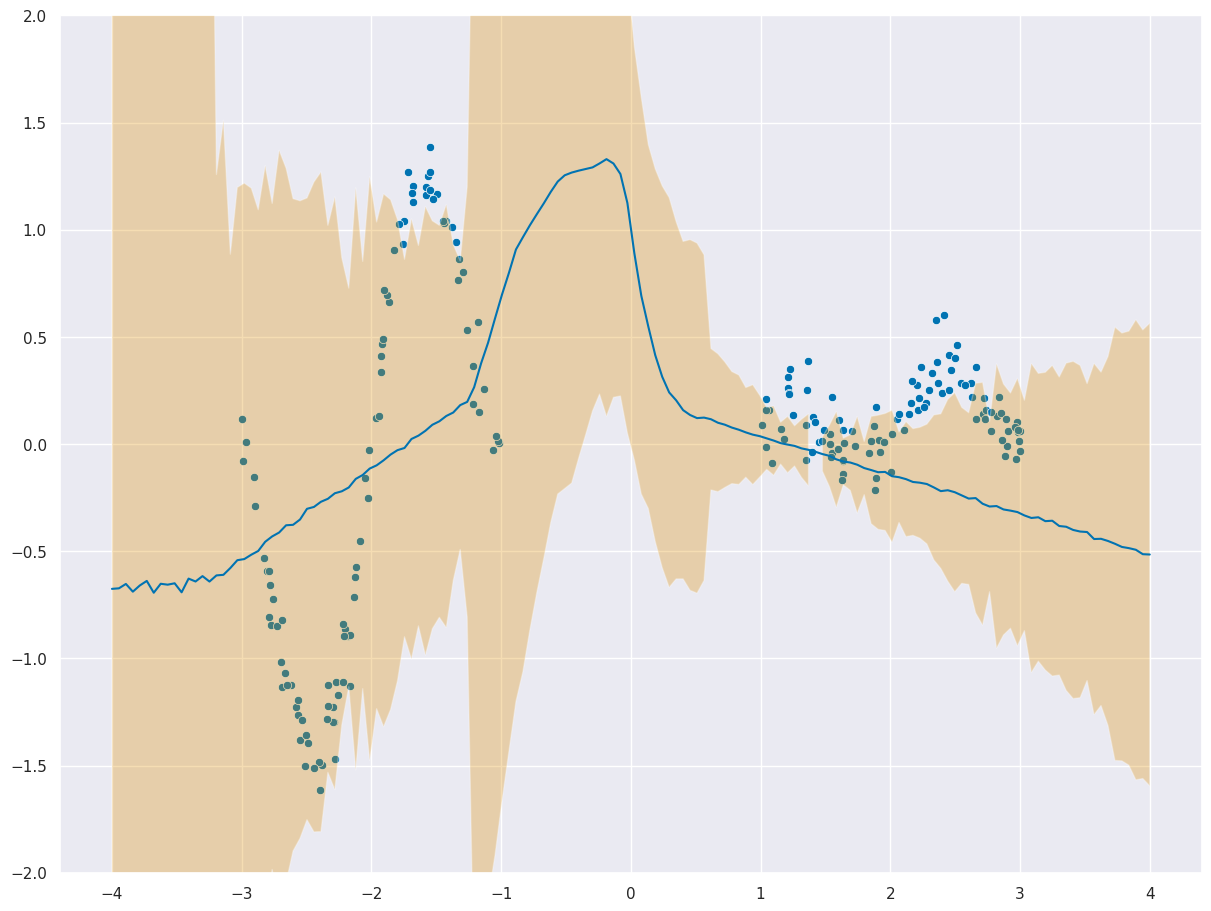

In [74]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

### 2.2.2 Multiple Passes (n=50)

In [75]:
# 50 passes over the dataset
n_passes = 50
X_multiple_train, y_multiple_train = jnp.tile(X_inbtwn_train, n_passes), jnp.tile(y_inbtwn_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [76]:
# Run ORFit with memory equal to size of original training set
bel, _ = estimator2.scan(X_multiple_train, y_multiple_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 10,000 iterations: 100%|██████████| 10000/10000 [00:03<00:00, 3129.99it/s]


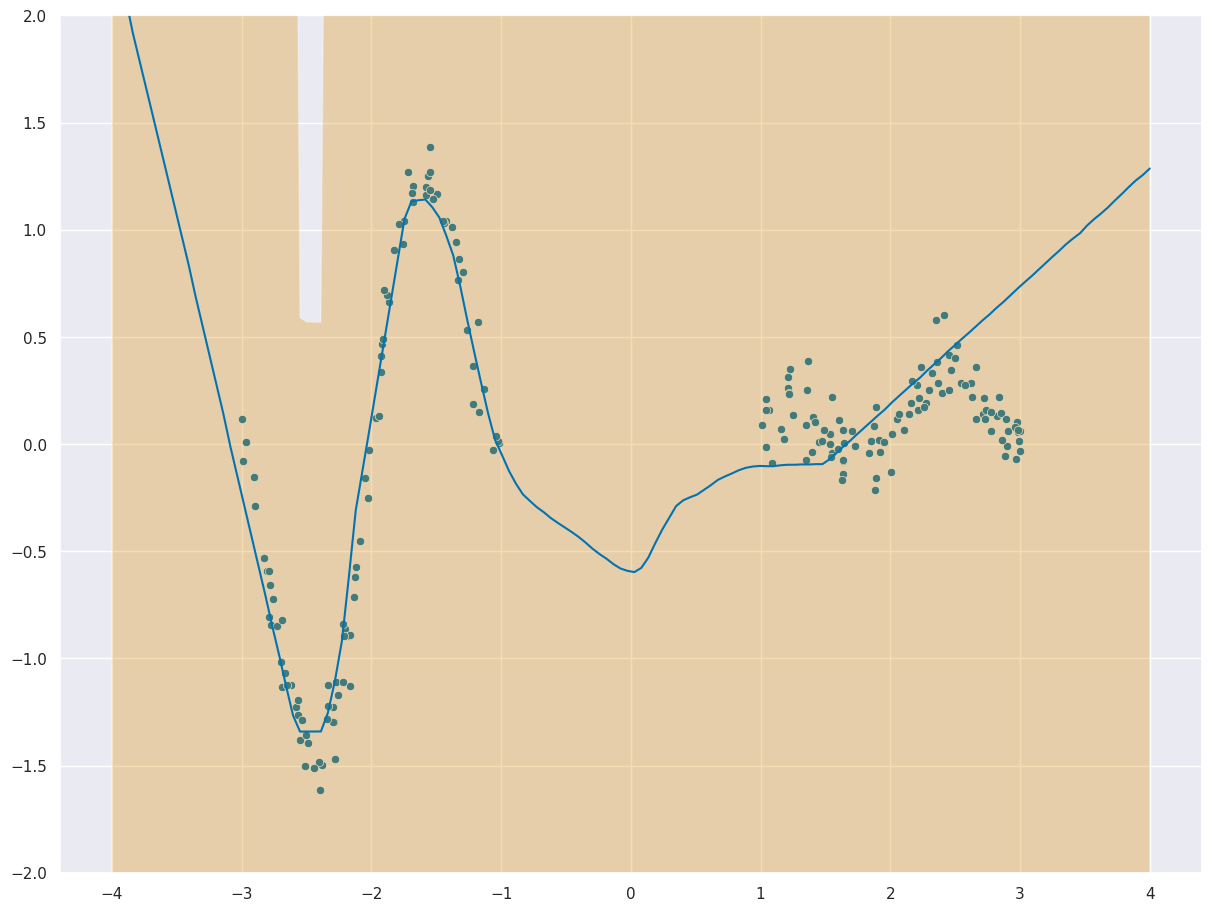

In [77]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

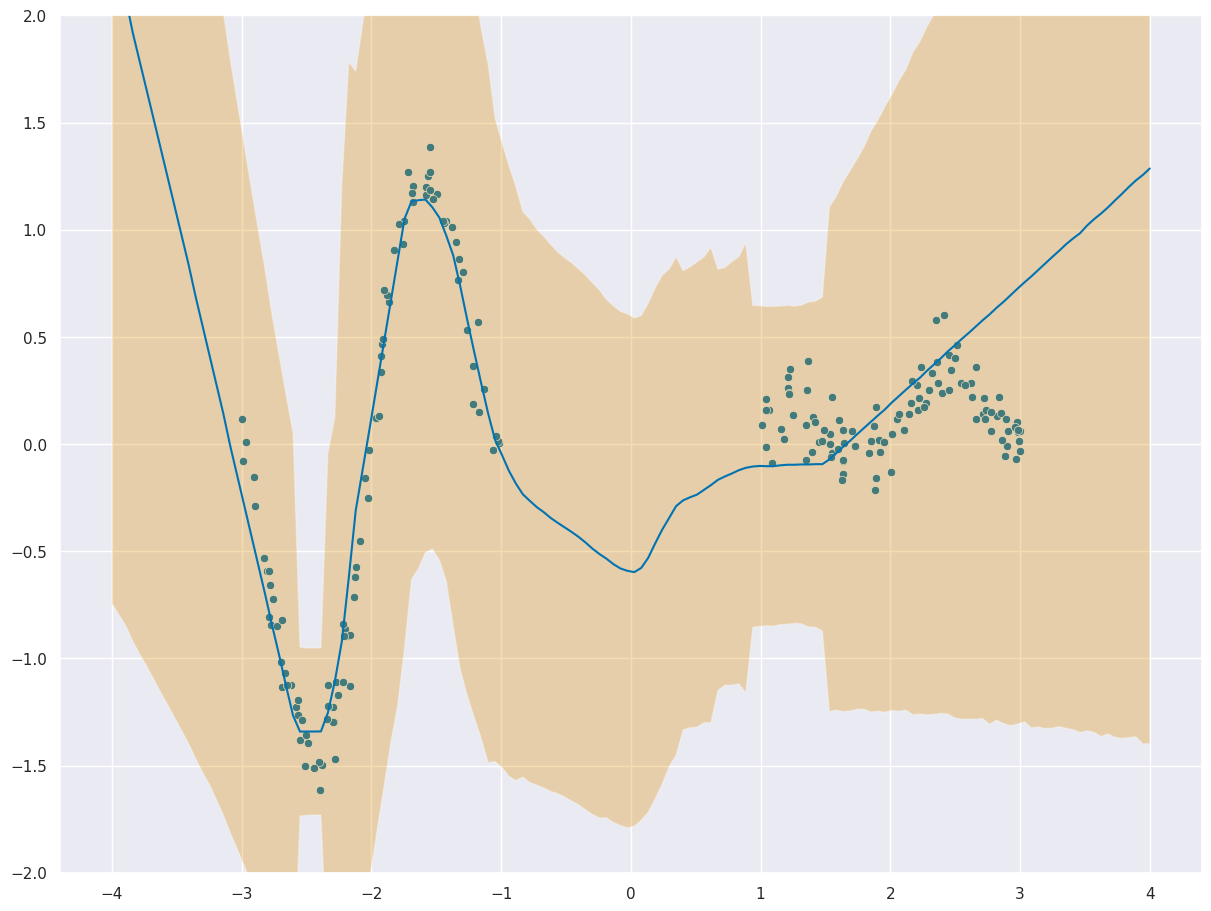

In [78]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.4*pred_std, pred_mean + 0.4*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

### 2.2.3 Multiple Passes (n=500)

In [79]:
# 500 passes over the dataset
n_passes = 500
X_multiple_train, y_multiple_train = jnp.tile(X_inbtwn_train, n_passes), jnp.tile(y_inbtwn_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [80]:
# Run ORFit with memory equal to size of original training set
bel, _ = estimator2.scan(X_multiple_train, y_multiple_train)

# Compute posterior predictive moments
pred_mean, pred_cov = vmap(orfit_posterior_predictive_moments, (None, 0, None, None))(apply_fn, X_grid, bel.mean, bel.basis)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

Running for 100,000 iterations: 100%|██████████| 100000/100000 [00:31<00:00, 3127.24it/s]


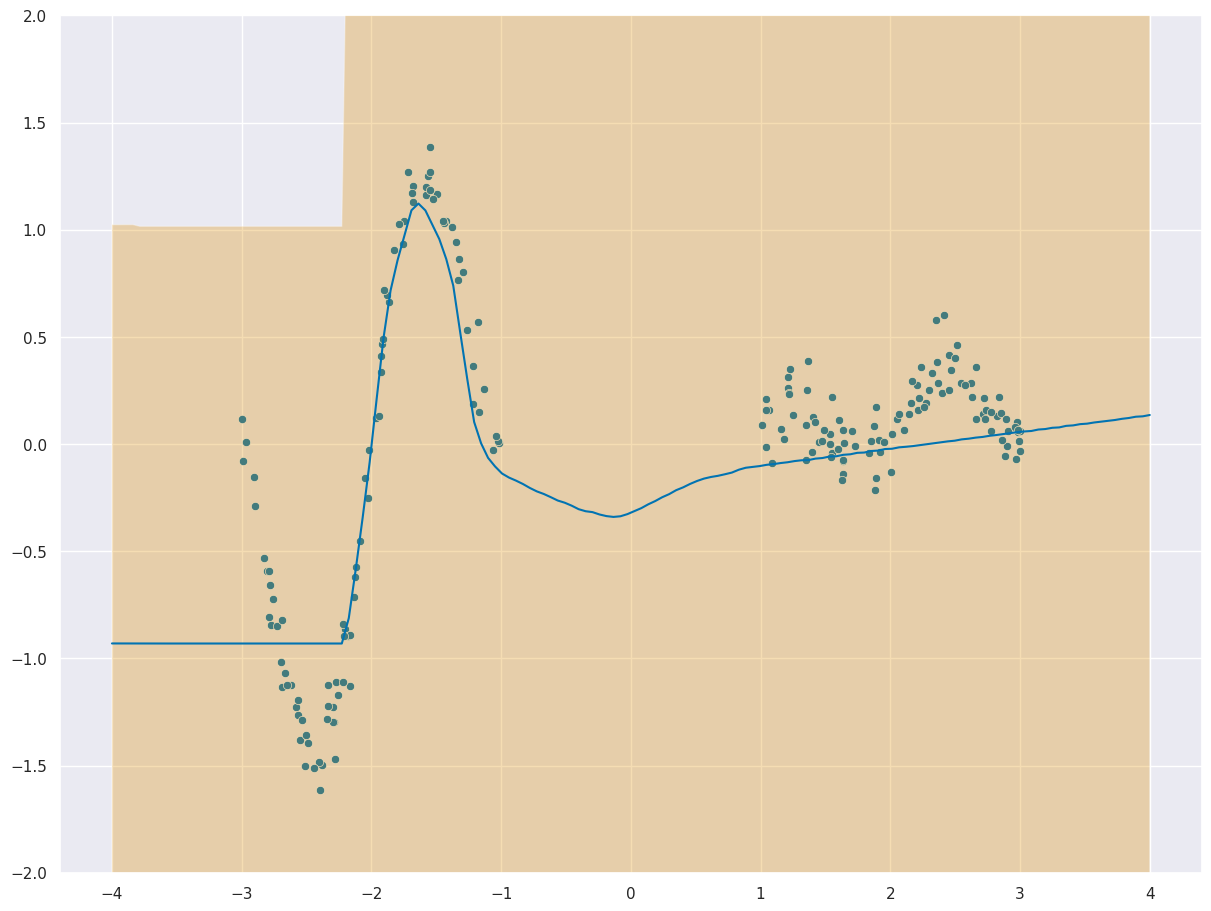

In [81]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

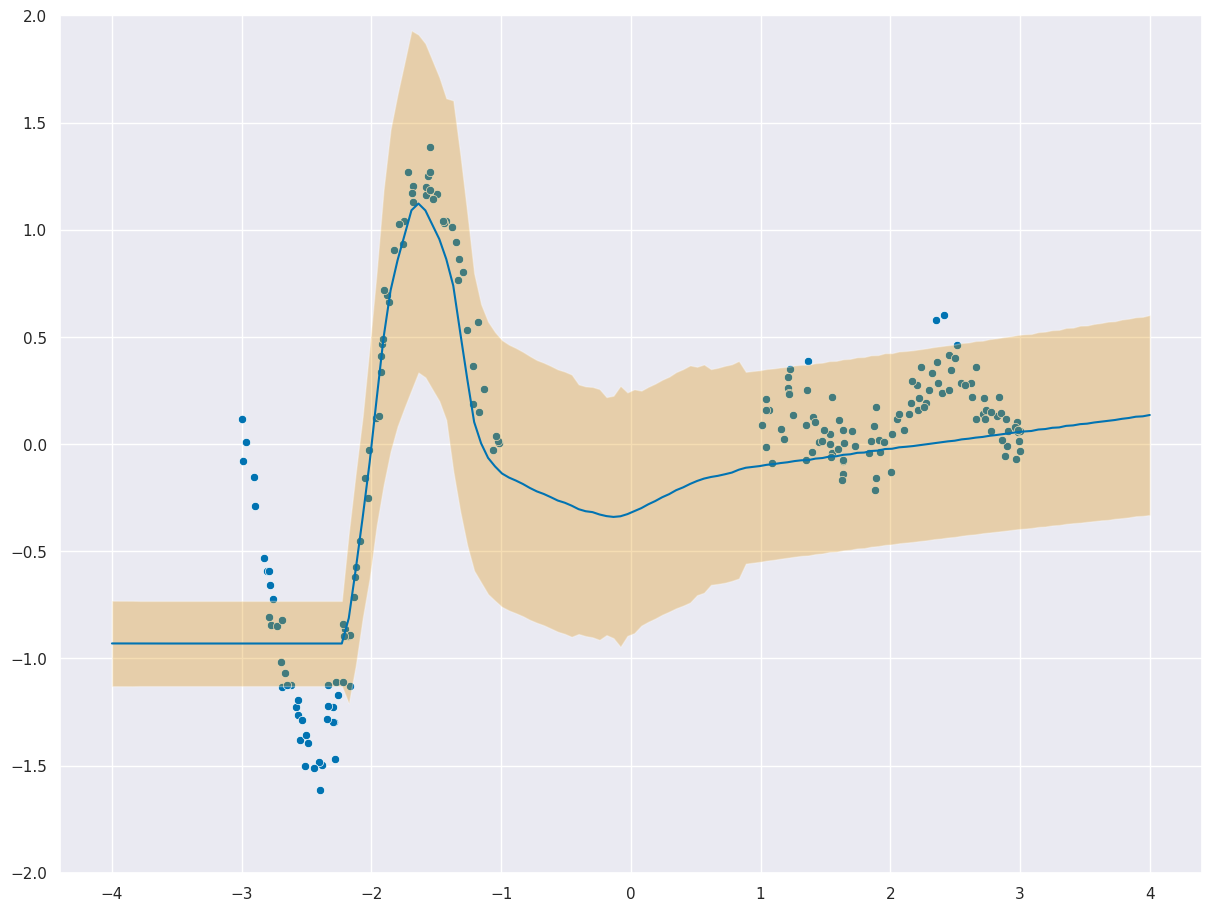

In [82]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_inbtwn_train, y=y_inbtwn_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 0.2*pred_std, pred_mean + 0.2*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

# 3. LoFi

In [93]:
def lofi_posterior_predictive_moments(apply_fn, eta_inv, x_to_pred, post_mean, post_basis, post_sigma):
    apply = lambda w: apply_fn(w, x_to_pred)
    eta = 1/eta_inv

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    W_tilde = post_sigma * post_basis
    S = eta*jnp.eye(W_tilde.shape[1]) + W_tilde.T @ W_tilde

    FW = F @ W_tilde
    pred_cov = F @ F.T - FW @ (jnp.linalg.pinv(S) @ FW.T)

    return pred_mean, pred_cov

## 3.1 Full Dataset

### 3.1.1 Hyperparameter Tuning

In [104]:
def lofi_opt_fn(log_init_cov):
    model_params = RebayesParams(
        initial_mean=flat_params,
        initial_covariance=jnp.power(10, log_init_cov).item(),
        dynamics_weights=1.0,
        dynamics_covariance=None,
        emission_mean_function=apply_fn,
        emission_cov_function=lambda w, x: None,
    )
    lofi_params = LoFiParams(
        memory_size=n_train,
    )
    estimator = RebayesLoFi(model_params, lofi_params, method='aov_lofi')

    bel, _ = estimator.scan(X_train, y_train)

    # Train RMSE
    y_pred = vmap(apply_fn, (None, 0))(bel.mean, X_train).squeeze()
    rmse = jnp.sqrt(((y_pred - y_train)**2).mean())
    if jnp.isnan(rmse):
        return -1e3

    return max(-rmse, -1e3)

In [105]:
lofi_optimizer = BayesianOptimization(
    f=lofi_opt_fn,
    pbounds={
        'log_init_cov': (-7.0, 0.0),
    }
)

In [106]:
lofi_optimizer.maximize(
    init_points=50,
    n_iter=50,
)

|   iter    |  target   | log_in... |
-------------------------------------


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 122.04it/s]


| 1         | -0.4098   | -0.1433   |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 178.37it/s]


| 2         | -0.4025   | -4.344    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 151.62it/s]


| 3         | -0.3363   | -3.401    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 141.67it/s]


| 4         | -0.3322   | -2.381    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 119.18it/s]


| 5         | -0.3969   | -0.7259   |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 119.63it/s]


| 6         | -0.3825   | -1.463    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 147.42it/s]


| 7         | -0.3256   | -3.074    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 130.67it/s]


| 8         | -0.3434   | -2.193    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 177.19it/s]


| 9         | -0.4093   | -4.525    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 195.92it/s]


| 10        | -0.419    | -4.981    |


Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 200.62it/s]


| 11        | -0.4241   | -6.081    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 152.12it/s]


| 12        | -0.3271   | -3.158    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 196.71it/s]


| 13        | -0.4184   | -4.938    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 197.82it/s]


| 14        | -0.424    | -6.019    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 116.39it/s]


| 15        | -0.3897   | -0.9405   |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 148.07it/s]


| 16        | -0.3237   | -2.865    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 199.99it/s]


| 17        | -0.4239   | -5.933    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 122.44it/s]


| 18        | -0.4083   | -0.0422   |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 195.63it/s]


| 19        | -0.4156   | -4.772    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 151.44it/s]


| 20        | -0.3257   | -3.079    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 118.53it/s]


| 21        | -0.4108   | -0.2094   |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 149.57it/s]


| 22        | -0.3248   | -2.999    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 123.17it/s]


| 23        | -0.4066   | -0.04847  |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 136.80it/s]


| 24        | -0.355    | -2.023    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 191.99it/s]


| 25        | -0.4162   | -4.801    |


Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 203.87it/s]


| 26        | -0.4234   | -5.624    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 151.77it/s]


| 27        | -0.3263   | -3.119    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 162.91it/s]


| 28        | -0.3668   | -3.805    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 121.94it/s]


| 29        | -0.371    | -1.758    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 135.62it/s]


| 30        | -0.3253   | -2.57     |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 177.57it/s]


| 31        | -0.3707   | -3.855    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 135.00it/s]


| 32        | -0.3578   | -1.974    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 142.64it/s]


| 33        | -0.3245   | -2.968    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 160.59it/s]


| 34        | -0.3498   | -3.599    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 183.63it/s]


| 35        | -0.3948   | -4.187    |


Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 202.23it/s]


| 36        | -0.4236   | -5.754    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 132.99it/s]


| 37        | -0.3571   | -1.994    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 114.78it/s]


| 38        | -0.3941   | -0.869    |


Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 201.62it/s]


| 39        | -0.4234   | -5.62     |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 113.02it/s]


| 40        | -0.3915   | -0.8081   |


Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 204.94it/s]


| 41        | -0.4246   | -6.718    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 123.01it/s]


| 42        | -0.415    | -0.04998  |


Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 205.02it/s]


| 43        | -0.4246   | -6.952    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 114.17it/s]


| 44        | -0.3976   | -0.6684   |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 198.19it/s]


| 45        | -0.419    | -4.979    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 122.64it/s]


| 46        | -0.41     | -0.1246   |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 198.48it/s]


| 47        | -0.4208   | -5.143    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 130.96it/s]


| 48        | -0.3573   | -1.986    |


Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 200.20it/s]


| 49        | -0.4239   | -5.96     |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 119.14it/s]


| 50        | -0.4065   | -0.1888   |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 145.29it/s]


| 51        | -0.3246   | -2.984    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 148.71it/s]


| 52        | -0.3256   | -3.074    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 152.99it/s]


| 53        | -0.3266   | -3.139    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 151.65it/s]


| 54        | -0.326    | -3.101    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 145.10it/s]


| 55        | -0.3237   | -2.849    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 136.94it/s]


| 56        | -0.3256   | -2.553    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 145.24it/s]


| 57        | -0.3249   | -3.019    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 147.82it/s]


| 58        | -0.3252   | -3.045    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 127.91it/s]


| 59        | -0.3334   | -2.36     |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 145.70it/s]


| 60        | -0.3244   | -2.946    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 151.28it/s]


| 61        | -0.3241   | -2.924    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 150.65it/s]


| 62        | -0.3239   | -2.897    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 147.38it/s]


| 63        | -0.3235   | -2.825    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 150.46it/s]


| 64        | -0.3235   | -2.802    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 146.55it/s]


| 65        | -0.3234   | -2.778    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 149.17it/s]


| 66        | -0.3234   | -2.753    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 146.61it/s]


| 67        | -0.3234   | -2.729    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 143.43it/s]


| 68        | -0.3235   | -2.704    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 148.40it/s]


| 69        | -0.3236   | -2.678    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 138.29it/s]


| 70        | -0.3239   | -2.653    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 135.64it/s]


| 71        | -0.3244   | -2.626    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 135.14it/s]


| 72        | -0.3247   | -2.599    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 137.07it/s]


| 73        | -0.3263   | -2.524    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 139.00it/s]


| 74        | -0.3272   | -2.497    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 127.95it/s]


| 75        | -0.328    | -2.468    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 131.77it/s]


| 76        | -0.3292   | -2.439    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 132.39it/s]


| 77        | -0.3305   | -2.411    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 150.65it/s]


| 78        | -0.3278   | -3.188    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 152.84it/s]


| 79        | -0.3286   | -3.217    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 154.99it/s]


| 80        | -0.3296   | -3.247    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 151.83it/s]


| 81        | -0.3307   | -3.278    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 159.12it/s]


| 82        | -0.3319   | -3.309    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 155.57it/s]


| 83        | -0.3345   | -3.367    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 155.25it/s]


| 84        | -0.3332   | -3.337    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 161.15it/s]


| 85        | -0.3381   | -3.435    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 125.64it/s]


| 86        | -0.3352   | -2.326    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 126.85it/s]


| 87        | -0.3365   | -2.292    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 130.47it/s]


| 88        | -0.339    | -2.256    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 127.99it/s]


| 89        | -0.3413   | -2.225    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 159.19it/s]


| 90        | -0.3404   | -3.471    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 152.40it/s]


| 91        | -0.3429   | -3.509    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 159.44it/s]


| 92        | -0.3459   | -3.549    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 126.02it/s]


| 93        | -0.346    | -2.153    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 131.07it/s]


| 94        | -0.3485   | -2.112    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 129.82it/s]


| 95        | -0.3517   | -2.071    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 159.83it/s]


| 96        | -0.3535   | -3.644    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 165.77it/s]


| 97        | -0.3579   | -3.696    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 118.25it/s]


| 98        | -0.3631   | -1.895    |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 199.85it/s]


| 99        | -0.4244   | -6.4      |


Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 121.65it/s]

| 100       | -0.3861   | -1.203    |


In [107]:
# 'log_init_cov': -2.7533315118469908
print(lofi_optimizer.max)

{'target': -0.3234156370162964, 'params': {'log_init_cov': -2.7533315118469908}}


### 3.1.2 Single Pass

In [108]:
# Initialize orfit estimator
model_params2 = RebayesParams(
    initial_mean=flat_params,
    initial_covariance=jnp.power(10, -2.7533315118469908).item(),
    dynamics_weights=1.0,
    dynamics_covariance=None,
    emission_mean_function=apply_fn,
    emission_cov_function = lambda w, x: None,
)
lofi_estimator = RebayesLoFi(model_params2, orfit_params1, method='aov_lofi')

In [109]:
# Run infinite-memory aov lofi
bel, _ = lofi_estimator.scan(X_train, y_train)

Running for 200 iterations: 100%|██████████| 200/200 [00:01<00:00, 146.49it/s]


In [110]:
# Compute posterior predictive moments
lofi_ppd = lambda x: lofi_posterior_predictive_moments(
    apply_fn, 
    jnp.power(10, -3.1357690848643034).item(), 
    x, 
    bel.mean, 
    bel.basis, 
    bel.sigma
)

pred_mean, pred_cov = vmap(lofi_ppd)(X_grid)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

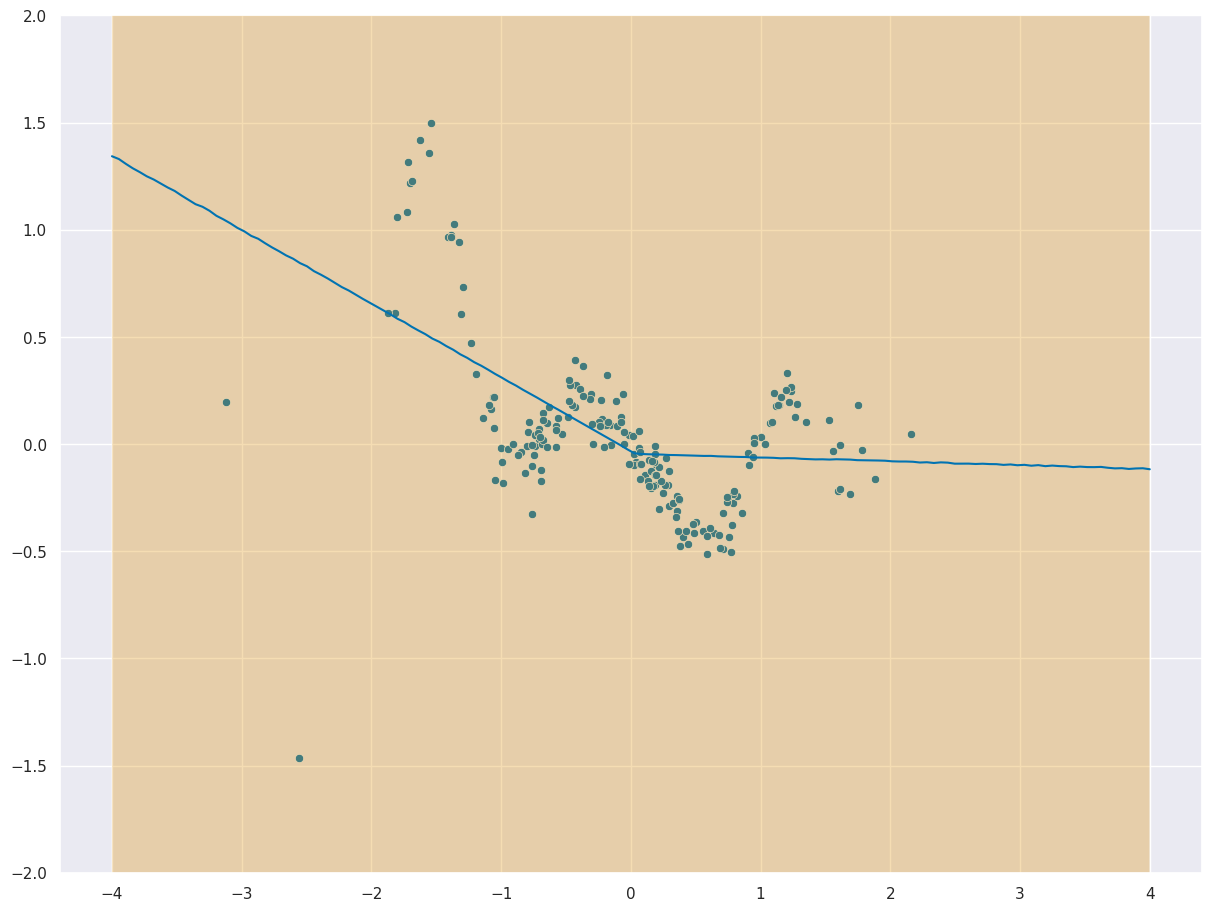

In [111]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);

### 3.1.3 Multiple Passes (n=50)

In [100]:
# 50 passes over the dataset
n_passes = 50
X_multiple_train, y_multiple_train = jnp.tile(X_train, n_passes), jnp.tile(y_train, n_passes)
idx_perm = jr.permutation(jr.PRNGKey(0), jnp.arange(len(X_multiple_train)))
X_multiple_train, y_multiple_train = X_multiple_train[idx_perm], y_multiple_train[idx_perm]

In [101]:
# Run infinite-memory aov lofi
bel, _ = lofi_estimator.scan(X_multiple_train, y_multiple_train)

Running for 10,000 iterations: 100%|██████████| 10000/10000 [01:06<00:00, 150.76it/s]


In [102]:
pred_mean, pred_cov = vmap(lofi_ppd)(X_grid)
pred_mean, pred_cov, pred_std = pred_mean.squeeze(), jnp.diag(pred_cov.squeeze()), jnp.sqrt(pred_cov.squeeze())

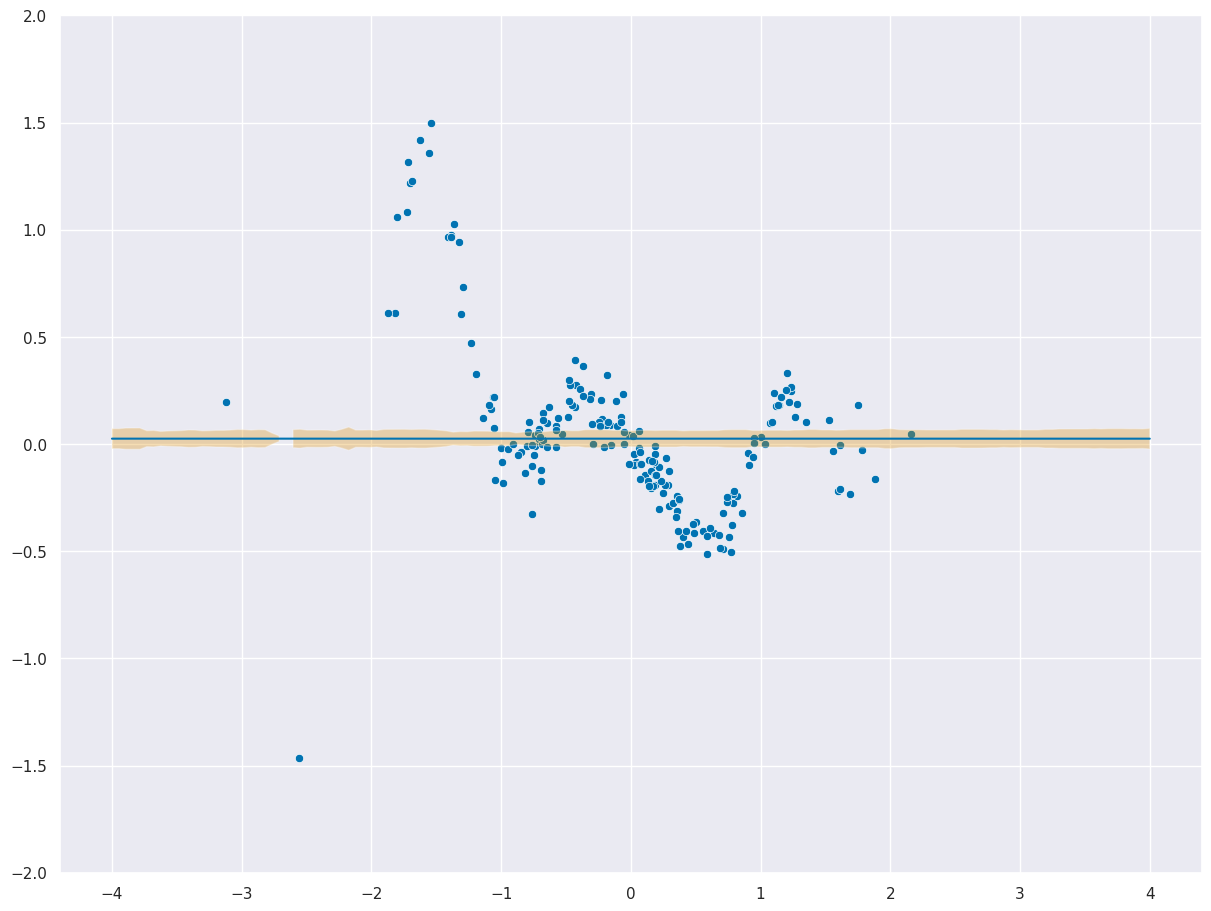

In [103]:
# Visualize the uncertainty results
fig, ax = plt.subplots()
ax = sns.scatterplot(x=X_train, y=y_train, ax=ax)
ax = sns.lineplot(x=X_grid, y=pred_mean, ax=ax)
ax.fill_between(
    X_grid, pred_mean - 1.96*pred_std, pred_mean + 1.96*pred_std, alpha=0.3
)
ax.set_ylim(-2., 2.);